In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    Input,
    Dense, 
    Conv2D,
    Conv2DTranspose, 
    ZeroPadding2D,
    BatchNormalization, 
    Reshape, 
    LeakyReLU,
    Dropout,
    Flatten,
    ReLU,
    Activation
)
from tensorflow.keras.preprocessing.image import (
    img_to_array,
    load_img
)
from tensorflow.keras.optimizers import Adam

In [2]:
# file_list = tf.data.Dataset.list_files('../data/*.png')

# # Make a Dataset of image tensors by reading and decoding the files
# image_dataset = file_list.map(lambda x: tf.io.decode_png(tf.io.read_file(x), channels=3))

# iterator = iter(image_dataset)

image_dataset = []
INPUT_DIR = "../data"
IMG_SIZE = 64

for image in os.listdir(INPUT_DIR):
    if ".png" in image:
        new_image = img_to_array(load_img(INPUT_DIR + "/" + image, target_size=(IMG_SIZE, IMG_SIZE))) / 255.
        image_dataset.append(new_image)
        flipped_image = np.fliplr(new_image)
        image_dataset.append(flipped_image)

image_dataset = np.array(image_dataset)
print(f"Number of images for training: {len(image_dataset)}")

Number of images for training: 1638


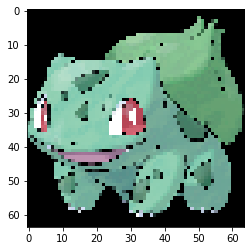

In [3]:
# Show a sample image from the dataset
# plt.imshow(iterator.get_next())

plt.imshow(image_dataset[0])

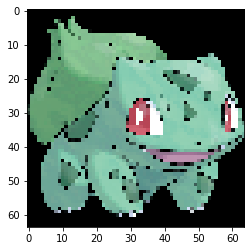

In [4]:
# Data Augmentation
# Creating new images by flipping/mirroring the existing images
# plt.imshow(np.fliplr(iterator.get_next()))

plt.imshow(image_dataset[1])

In [5]:
# flipped_images = []
# for image in image_dataset:
#   flipped_images.append(np.fliplr(image))

# flipped_image_dataset = tf.data.Dataset.from_tensor_slices(np.array(flipped_images))

In [6]:
# Combined image dataset (with flipped images)
# image_dataset = image_dataset.concatenate(flipped_image_dataset)

In [75]:
# Generator 

def generator(input_size):
    model = Sequential()
    
    model.add(Dense(4*4*512, activation="relu", input_shape=(input_size,)))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU())
    model.add(Reshape((4, 4, 512)))
    
    model.add(Conv2DTranspose(filters=1024, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())
    
    model.add(Conv2DTranspose(filters=512, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())
    
    model.add(Conv2DTranspose(filters=256, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())
    
    model.add(Conv2DTranspose(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())
    
#     model.add(Conv2DTranspose(filters=3, kernel_size=(4, 4), padding='same', activation='tanh'))
    model.add(Conv2D(filters=3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    
    input = Input(shape=(input_size,))
    
    generated_image = model(input)
    
    return Model(input, generated_image)


In [76]:
# Generator model summary
generator_model = generator(100)
generator_model.layers[1].summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 8192)              827392    
_________________________________________________________________
reshape_23 (Reshape)         (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_92 (Conv2DT (None, 8, 8, 1024)        8389632   
_________________________________________________________________
batch_normalization_118 (Bat (None, 8, 8, 1024)        4096      
_________________________________________________________________
re_lu_92 (ReLU)              (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_93 (Conv2DT (None, 16, 16, 512)       8389120   
_________________________________________________________________
batch_normalization_119 (Bat (None, 16, 16, 512)     

In [77]:
# Discriminator 

def discriminator(image_shape):
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(4, 4), strides=(2, 2), padding='same', input_shape=image_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
#     model.add(Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.4))
    
#     model.add(Conv2D(filters=128, kernel_size=(4, 4), strides=(1, 1), padding='same'))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.4))
    
#     model.add(Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 1), padding='same'))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    input_image = Input(shape=image_shape)
    
    prediction = model(input_image)
    
    return Model(input_image, prediction)

In [78]:
optimizer = Adam(1.5e-4, 0.5)
discriminator_optimizer = Adam(1.5e-4, 0.5)

image_shape = (IMG_SIZE, IMG_SIZE, 3)

discriminator_model = discriminator(image_shape)
discriminator_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator_model.trainable = False

seed_input_size = 100
random_input = Input(shape=(seed_input_size,))

generator_model = generator(seed_input_size)
generated_image = generator_model(random_input)

prediction = discriminator_model(generated_image)

combined_model = Model(random_input, prediction)
combined_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [79]:
# # Convert tensorflow dataset to numpy array
# images_numpy_array = list(tf.data.Dataset.as_numpy_iterator(image_dataset))
# images_numpy_array = np.array(images_numpy_array)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0
discriminator loss: [0.74008283 0.3515625 ] 
generator loss: [0.5055270195007324, 0.96875]


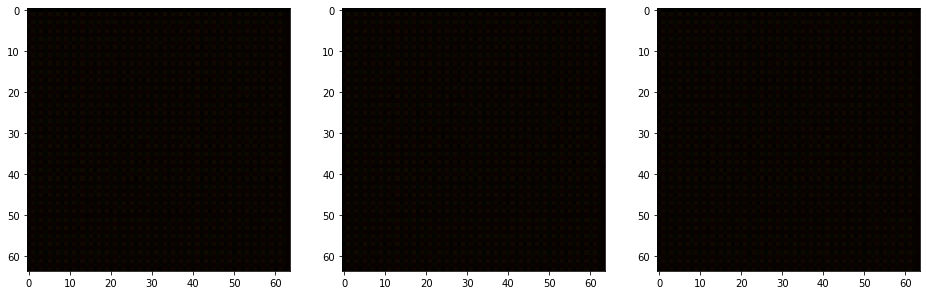

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 50
discriminator loss: [1.21876526 0.3125    ] 
generator loss: [0.1794857382774353, 0.984375]


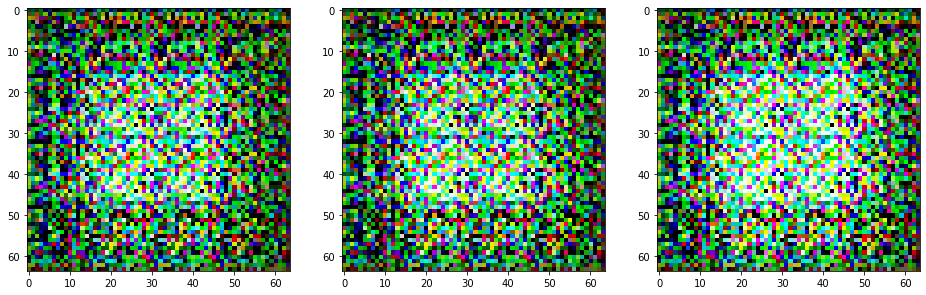

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 100
discriminator loss: [1.69397908 0.15625   ] 
generator loss: [0.23590049147605896, 0.921875]


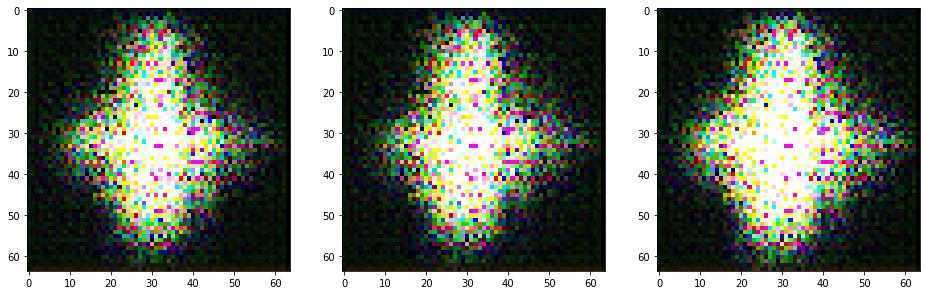

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 150
discriminator loss: [1.36884725 0.1796875 ] 
generator loss: [0.346876323223114, 0.921875]


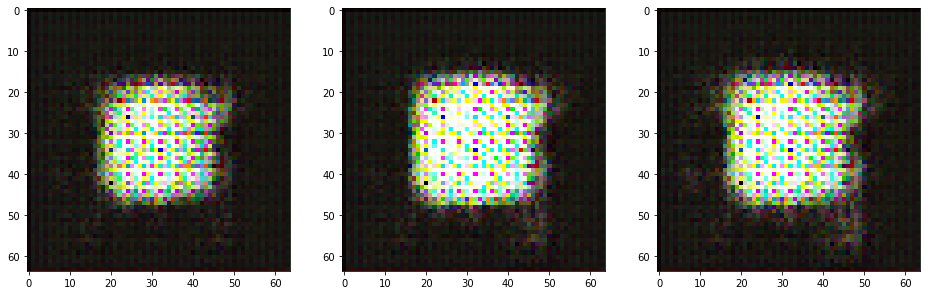

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 200
discriminator loss: [0.09269214 1.        ] 
generator loss: [0.1336376965045929, 1.0]


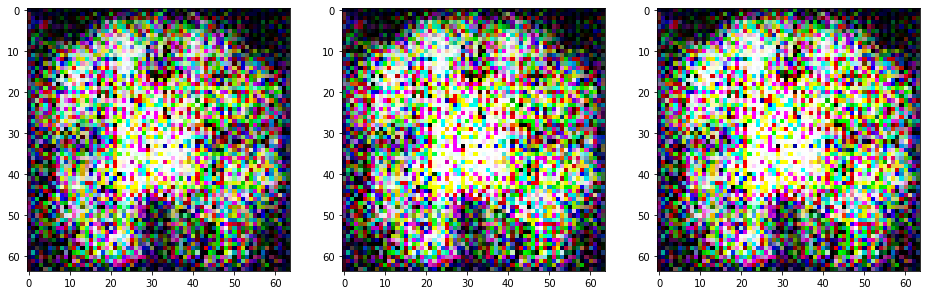

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 250
discriminator loss: [0.51554638 0.7578125 ] 
generator loss: [0.2560078501701355, 0.953125]


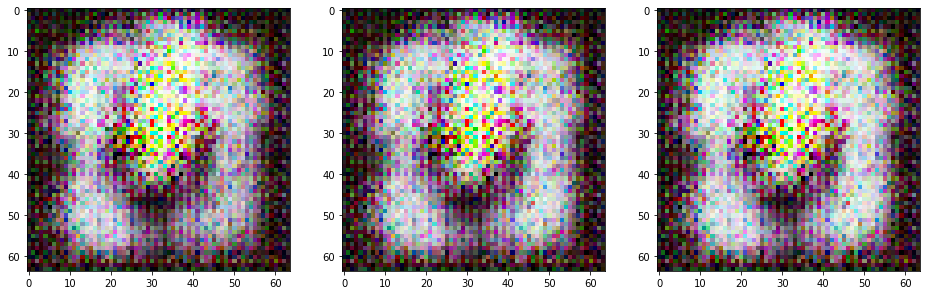

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 300
discriminator loss: [0.04096198 1.        ] 
generator loss: [0.43085718154907227, 0.78125]


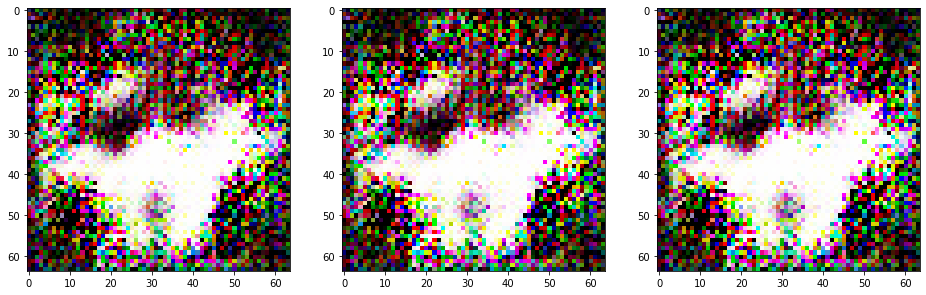

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 350
discriminator loss: [0.02249155 1.        ] 
generator loss: [0.7699729204177856, 0.53125]


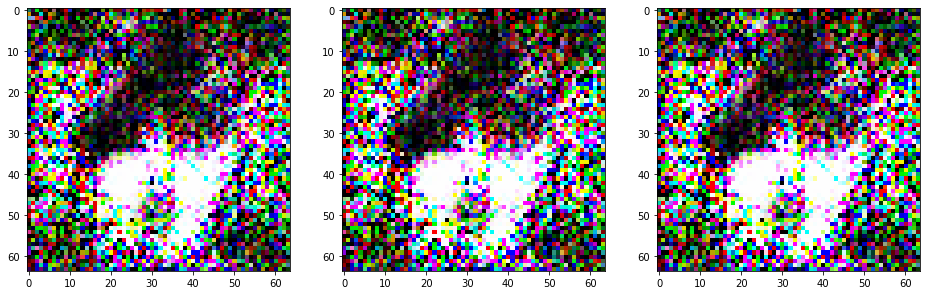

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 400
discriminator loss: [0.00902553 1.        ] 
generator loss: [1.3254543542861938, 0.125]


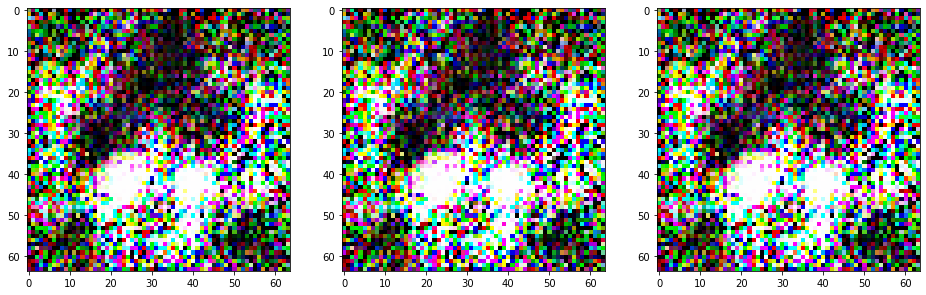

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 450
discriminator loss: [0.01257016 1.        ] 
generator loss: [0.7900362014770508, 0.5]


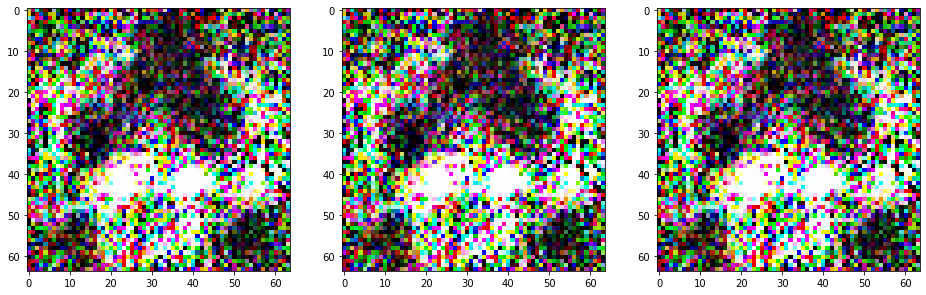

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 500
discriminator loss: [0.0568072 1.       ] 
generator loss: [0.7330473065376282, 0.46875]


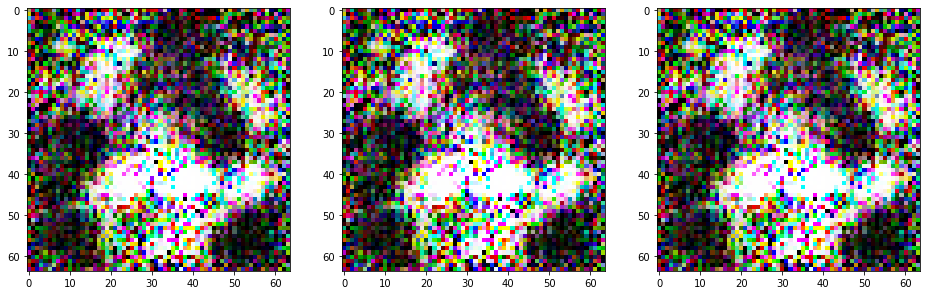

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 550
discriminator loss: [0.10039941 1.        ] 
generator loss: [0.4404475688934326, 0.84375]


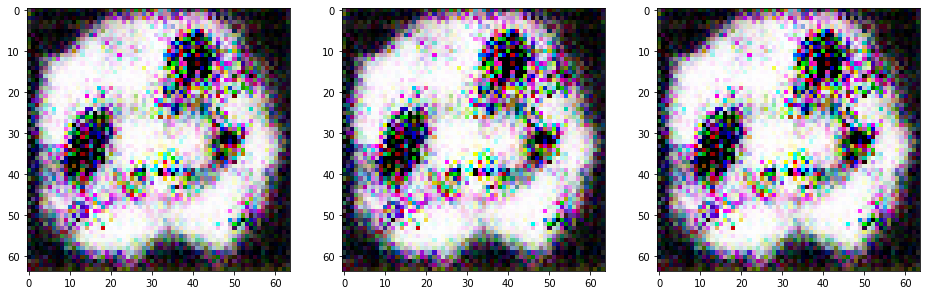

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 600
discriminator loss: [0.009907 1.      ] 
generator loss: [0.6918395161628723, 0.515625]


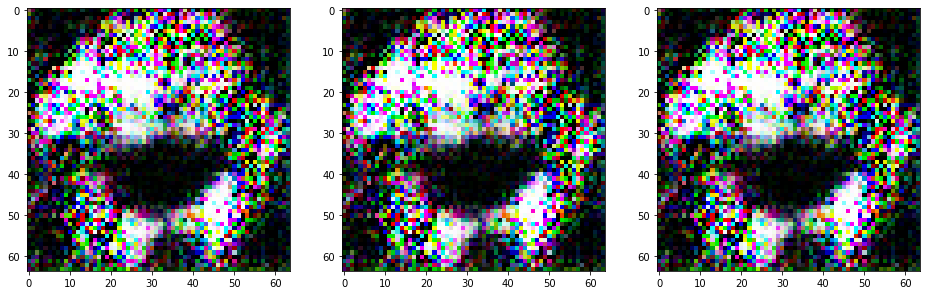

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 650
discriminator loss: [0.00453035 1.        ] 
generator loss: [1.5982773303985596, 0.015625]


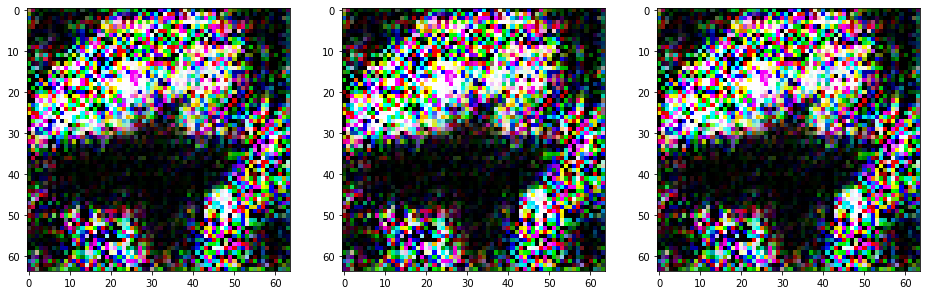

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 700
discriminator loss: [0.00569583 1.        ] 
generator loss: [0.7135651707649231, 0.546875]


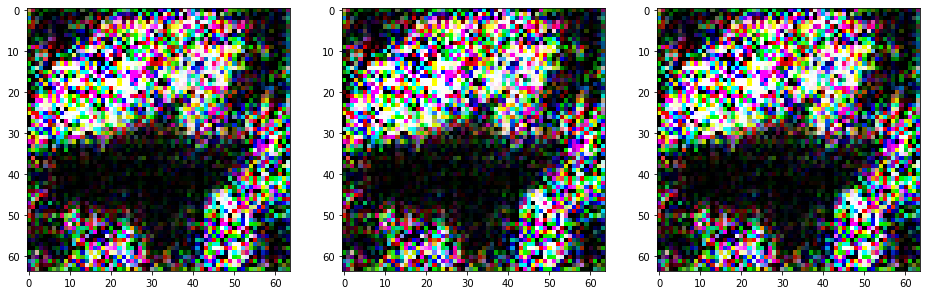

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 750
discriminator loss: [0.03710189 1.        ] 
generator loss: [1.079668641090393, 0.234375]


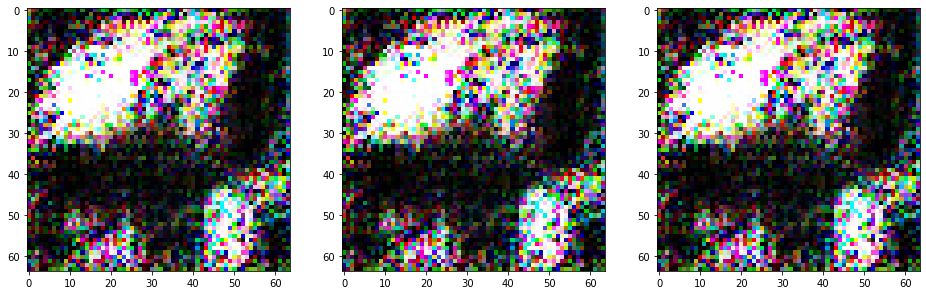

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 800
discriminator loss: [0.01223146 1.        ] 
generator loss: [0.46410906314849854, 0.8125]


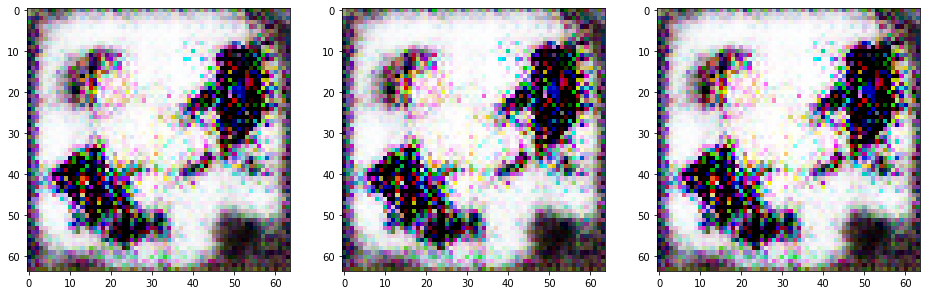

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 850
discriminator loss: [0.01665513 1.        ] 
generator loss: [0.7384361624717712, 0.546875]


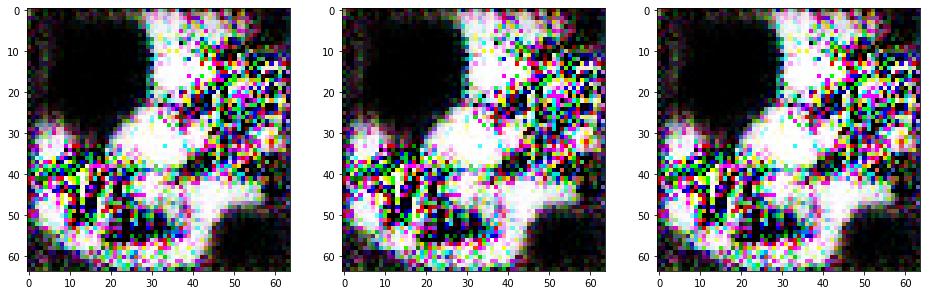

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 900
discriminator loss: [0.13876833 0.9765625 ] 
generator loss: [0.42826420068740845, 0.828125]


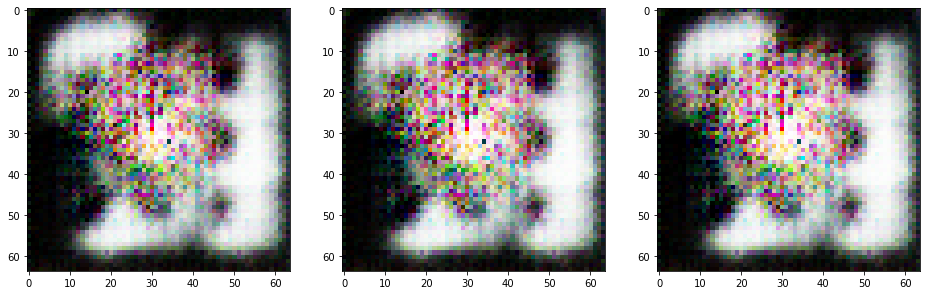

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 950
discriminator loss: [0.38275348 0.8515625 ] 
generator loss: [1.1770539283752441, 0.109375]


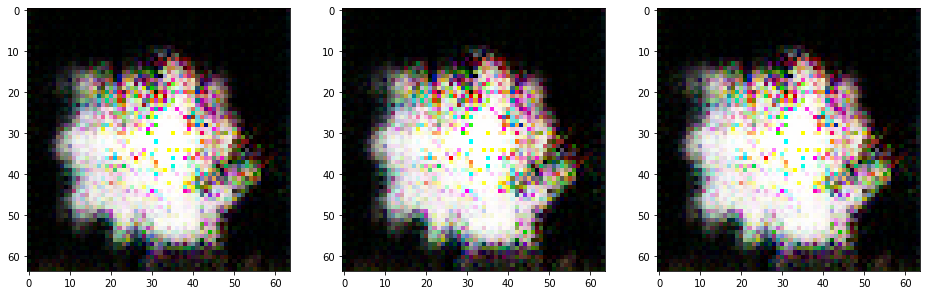

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1000
discriminator loss: [0.10004546 1.        ] 
generator loss: [0.7884498834609985, 0.453125]


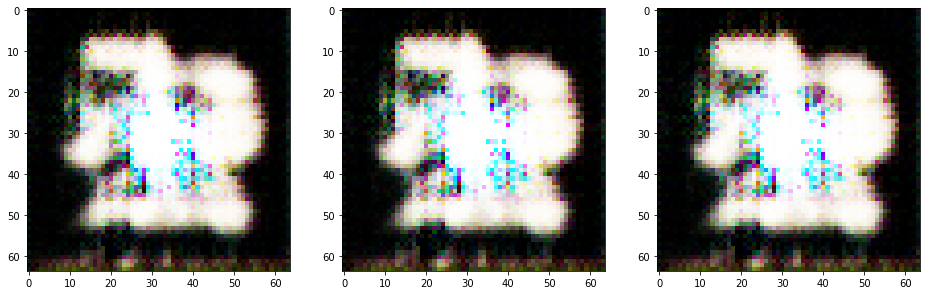

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1050
discriminator loss: [0.01677188 1.        ] 
generator loss: [0.5832369327545166, 0.765625]


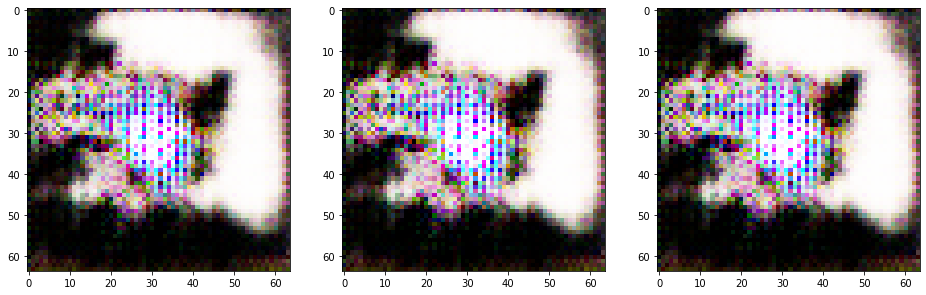

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1100
discriminator loss: [0.01101996 1.        ] 
generator loss: [1.0442795753479004, 0.28125]


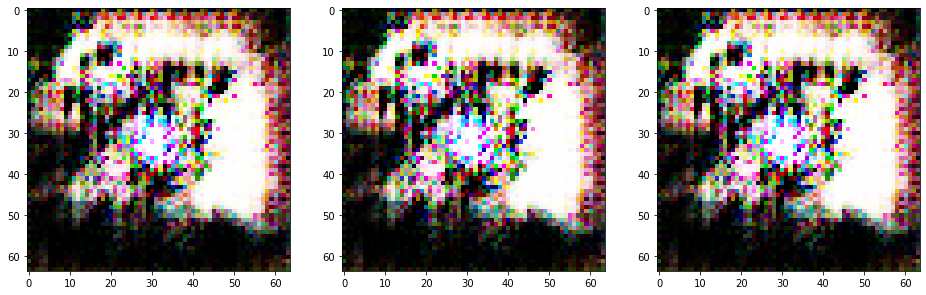

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1150
discriminator loss: [0.1628977 1.       ] 
generator loss: [0.6048805117607117, 0.671875]


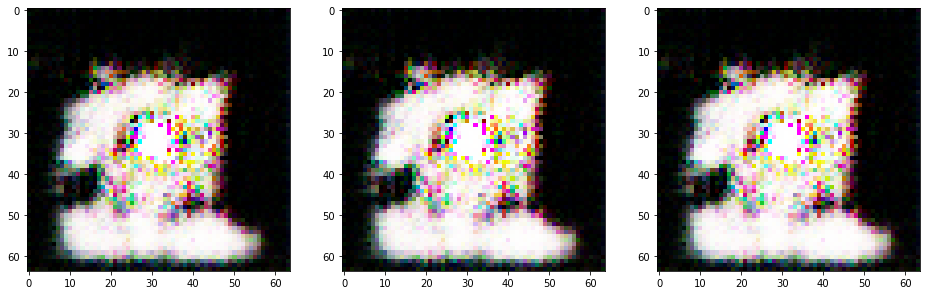

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1200
discriminator loss: [0.00155031 1.        ] 
generator loss: [0.962188184261322, 0.40625]


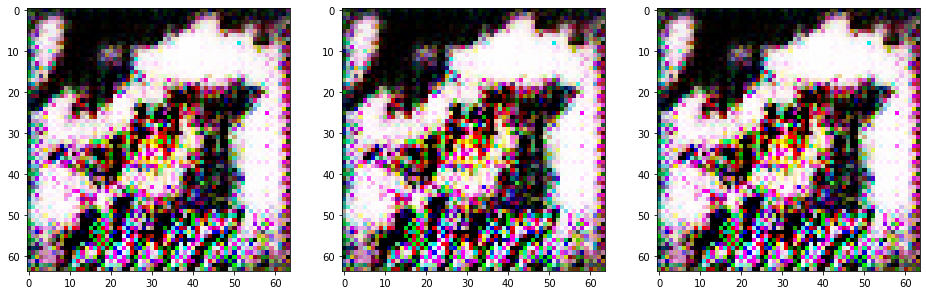

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1250
discriminator loss: [0.00402906 1.        ] 
generator loss: [0.6482646465301514, 0.609375]


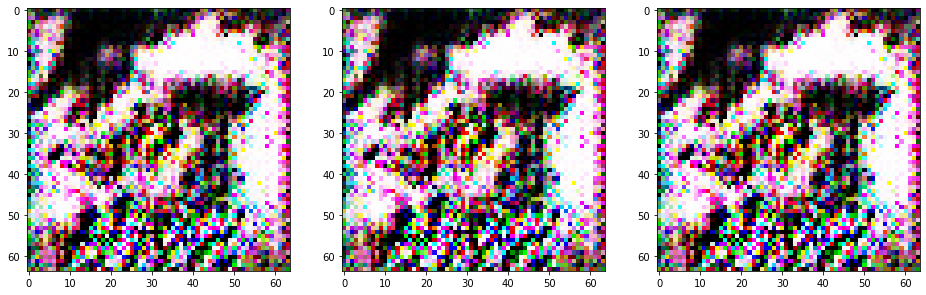

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1300
discriminator loss: [0.00241849 1.        ] 
generator loss: [1.2131438255310059, 0.21875]


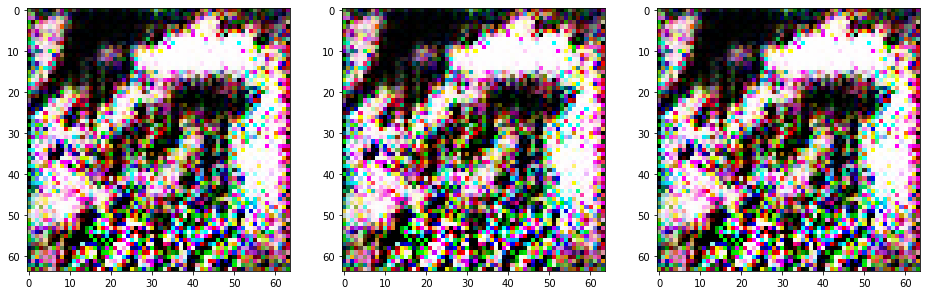

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1350
discriminator loss: [0.00348283 1.        ] 
generator loss: [0.634503960609436, 0.640625]


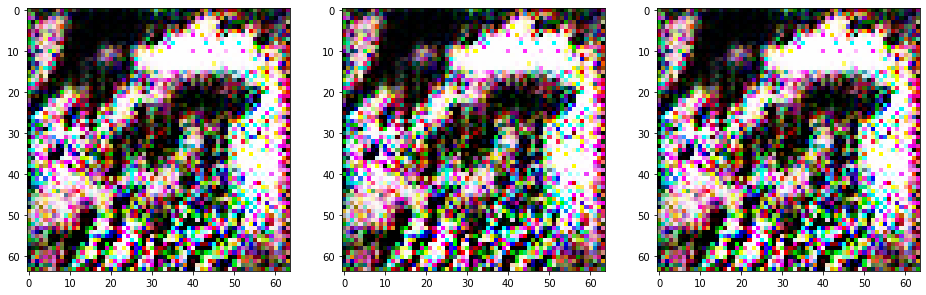

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1400
discriminator loss: [0.00382378 1.        ] 
generator loss: [1.1109168529510498, 0.28125]


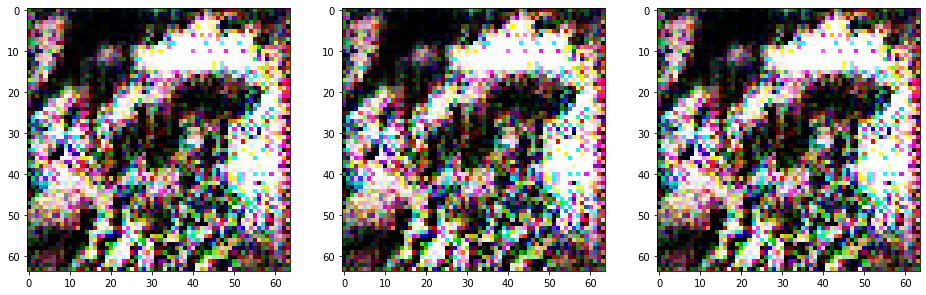

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1450
discriminator loss: [0.01389374 1.        ] 
generator loss: [1.385209083557129, 0.078125]


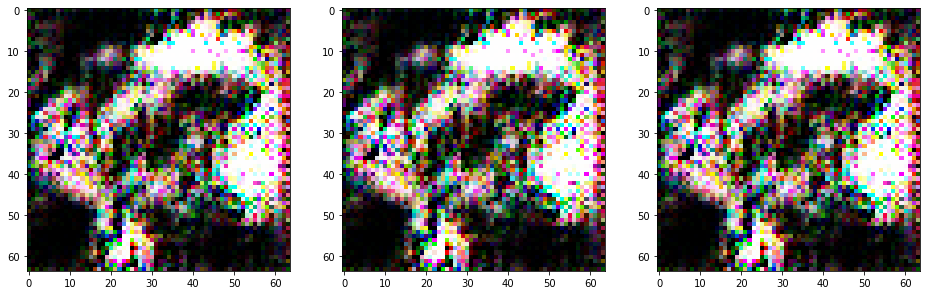

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1500
discriminator loss: [0.01110292 1.        ] 
generator loss: [0.737637460231781, 0.5]


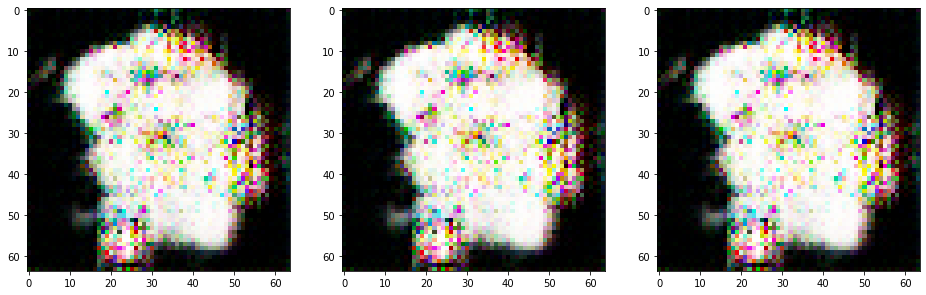

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1550
discriminator loss: [0.02045144 1.        ] 
generator loss: [0.674302339553833, 0.59375]


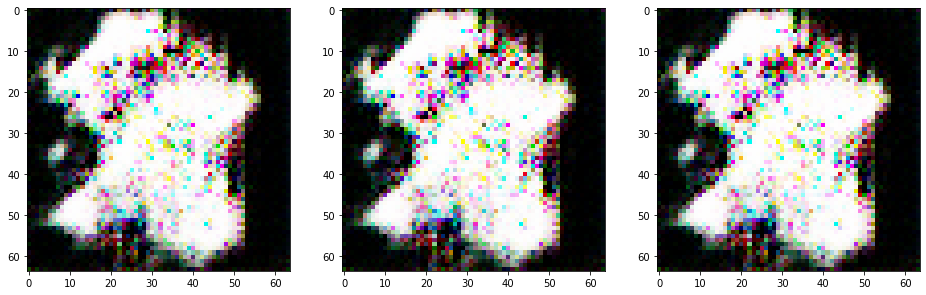

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1600
discriminator loss: [0.00425213 1.        ] 
generator loss: [1.1575764417648315, 0.28125]


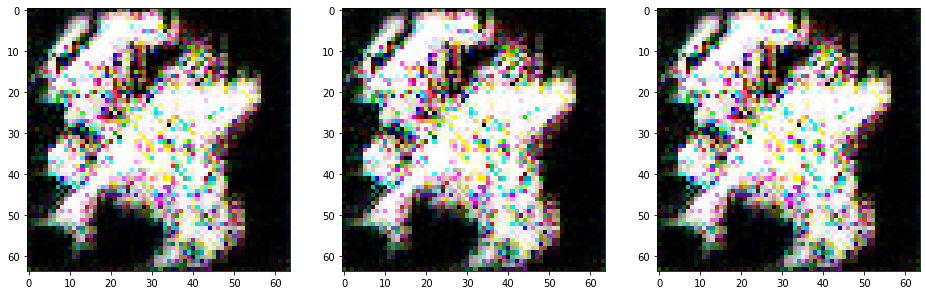

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1650
discriminator loss: [0.00287833 1.        ] 
generator loss: [0.8754843473434448, 0.390625]


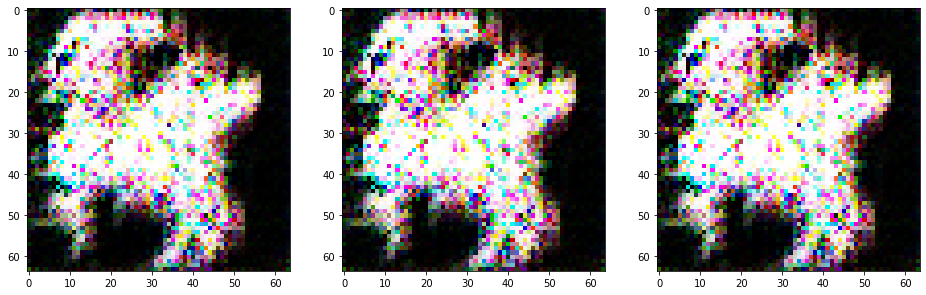

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1700
discriminator loss: [0.00279662 1.        ] 
generator loss: [1.1546945571899414, 0.21875]


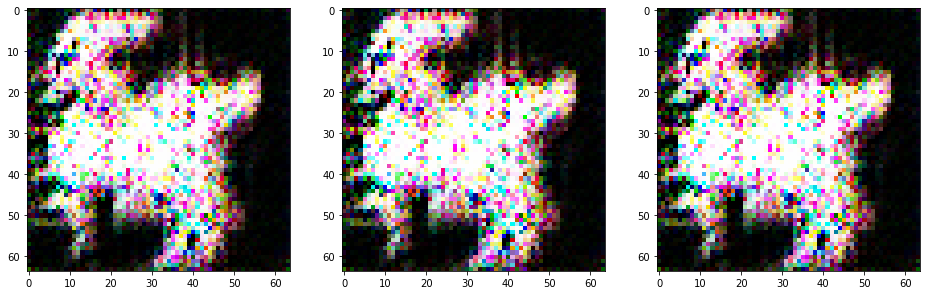

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1750
discriminator loss: [0.0085644 1.       ] 
generator loss: [1.1452646255493164, 0.140625]


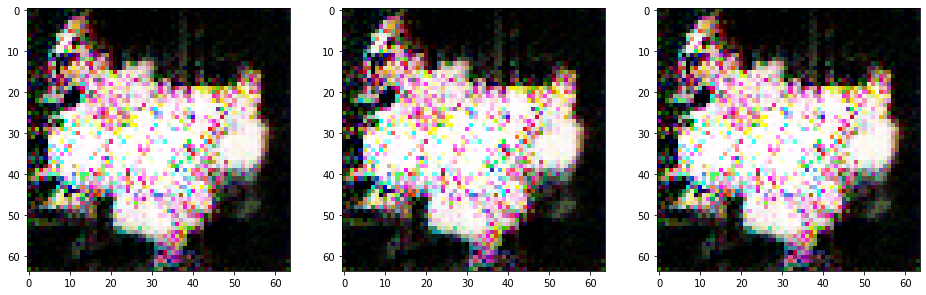

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1800
discriminator loss: [9.81797843e-04 1.00000000e+00] 
generator loss: [0.70831298828125, 0.609375]


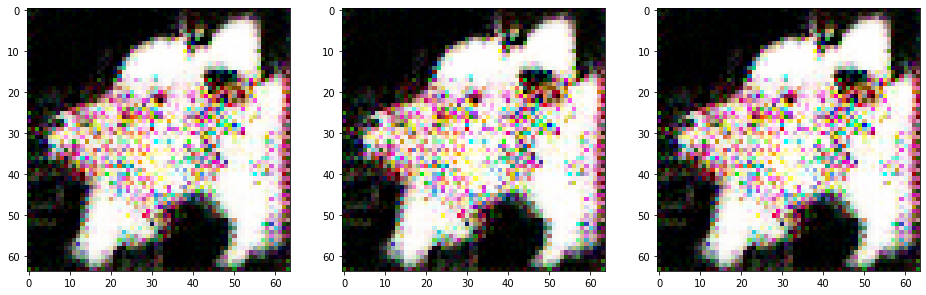

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1850
discriminator loss: [0.00471838 1.        ] 
generator loss: [0.9320372343063354, 0.421875]


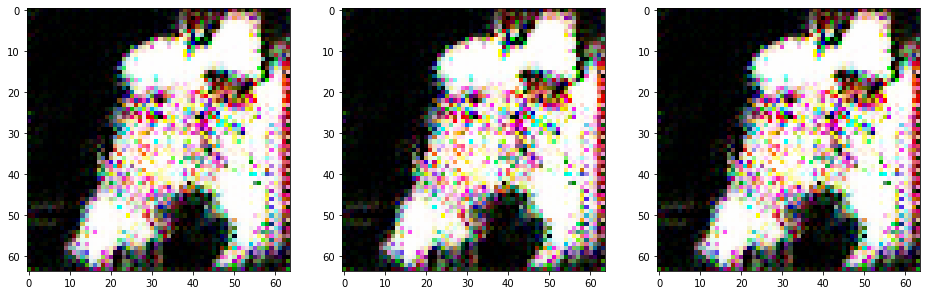

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1900
discriminator loss: [0.00181722 1.        ] 
generator loss: [1.5474815368652344, 0.140625]


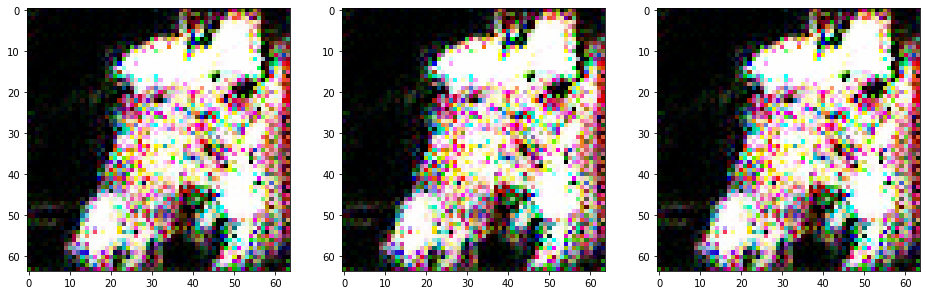

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1950
discriminator loss: [0.00977158 1.        ] 
generator loss: [1.0964114665985107, 0.171875]


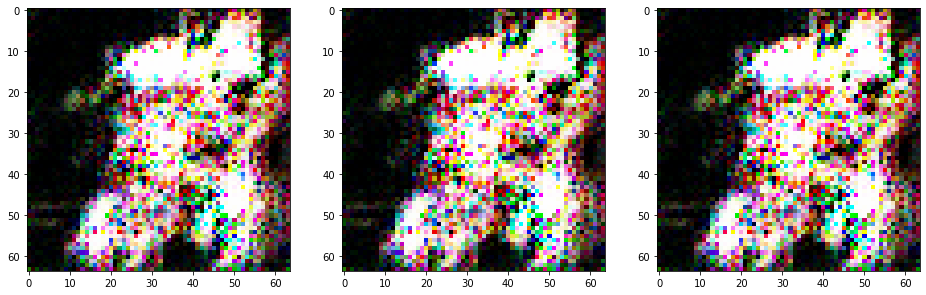

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2000
discriminator loss: [0.0095811 1.       ] 
generator loss: [1.1480448246002197, 0.109375]


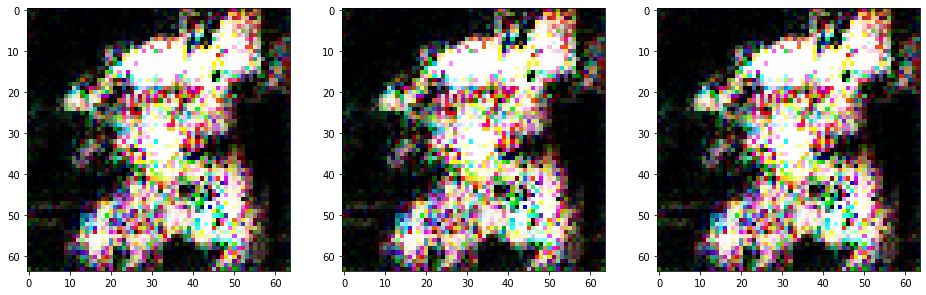

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2050
discriminator loss: [0.00127021 1.        ] 
generator loss: [0.43800631165504456, 0.796875]


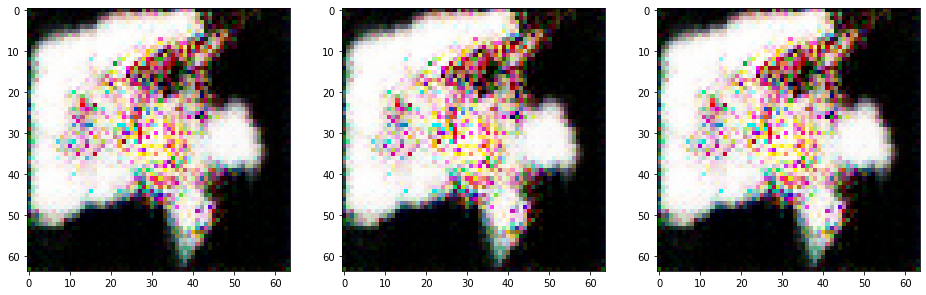

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2100
discriminator loss: [0.00178651 1.        ] 
generator loss: [0.6968355178833008, 0.5625]


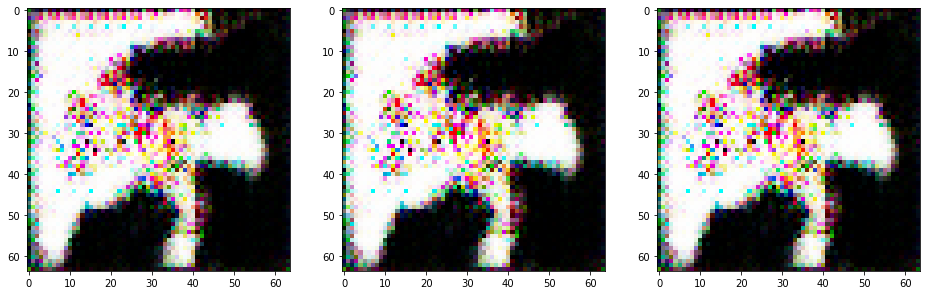

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2150
discriminator loss: [3.7921578e-04 1.0000000e+00] 
generator loss: [1.1817436218261719, 0.234375]


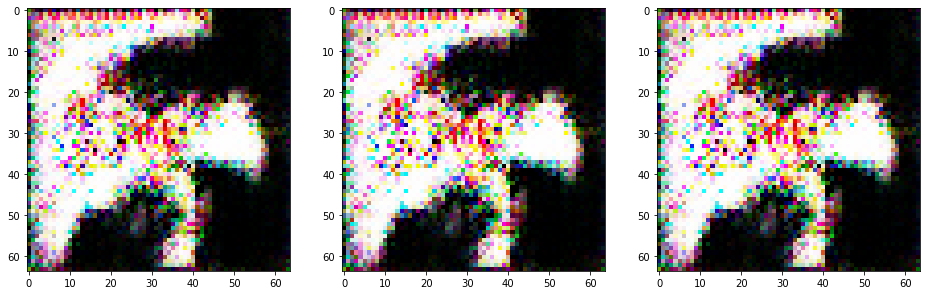

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2200
discriminator loss: [2.15826163e-04 1.00000000e+00] 
generator loss: [1.026287317276001, 0.3125]


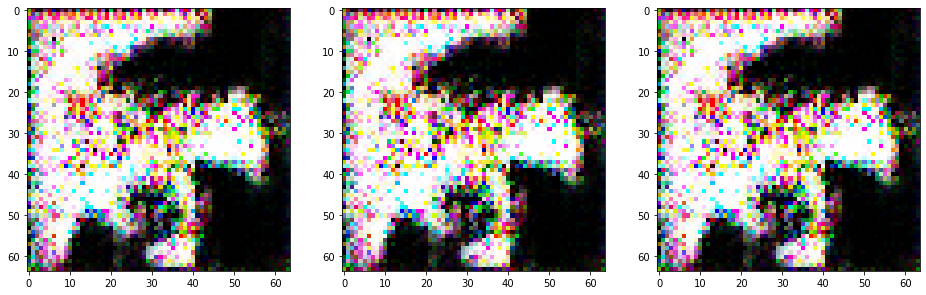

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2250
discriminator loss: [2.01337712e-04 1.00000000e+00] 
generator loss: [0.6679129600524902, 0.65625]


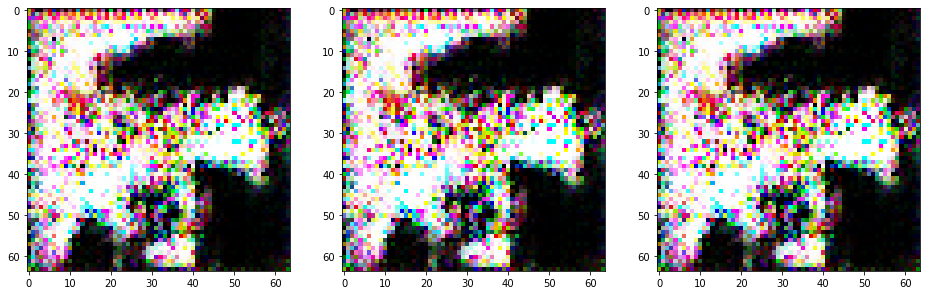

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2300
discriminator loss: [1.74094141e-04 1.00000000e+00] 
generator loss: [1.2575112581253052, 0.15625]


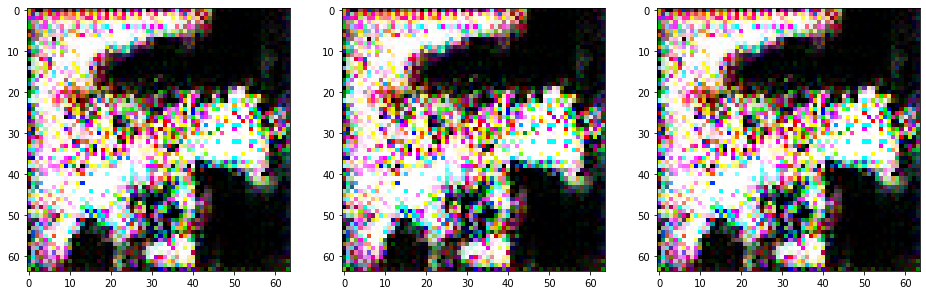

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2350
discriminator loss: [1.71748929e-04 1.00000000e+00] 
generator loss: [1.0129464864730835, 0.328125]


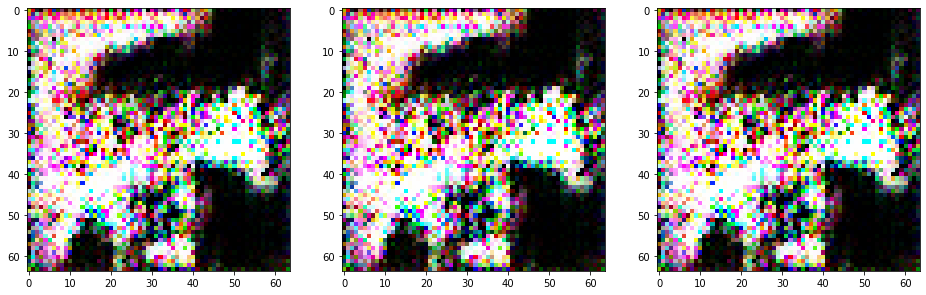

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2400
discriminator loss: [2.86044862e-04 1.00000000e+00] 
generator loss: [0.9260583519935608, 0.359375]


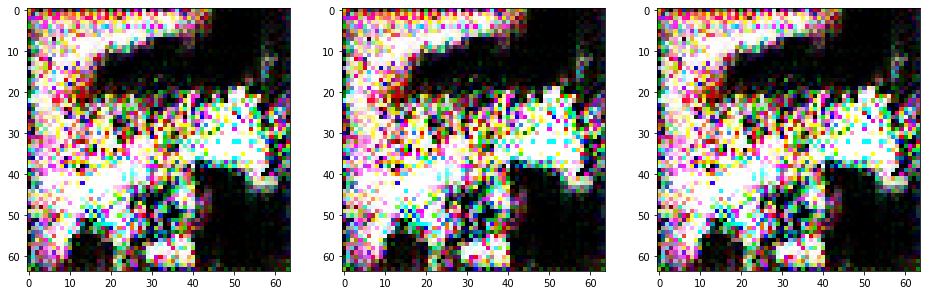

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2450
discriminator loss: [0.00151197 1.        ] 
generator loss: [1.1703945398330688, 0.125]


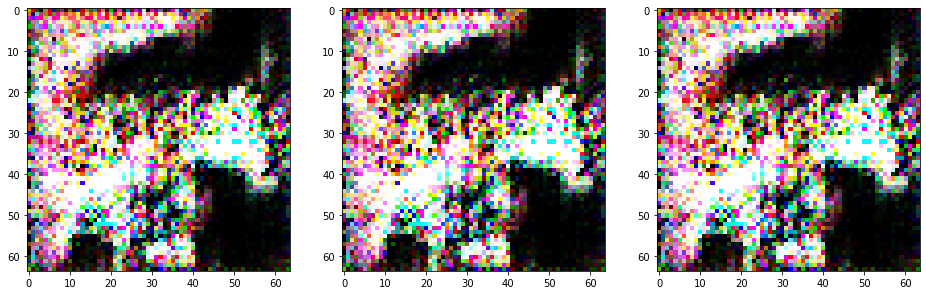

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2500
discriminator loss: [2.10239421e-04 1.00000000e+00] 
generator loss: [1.1244035959243774, 0.25]


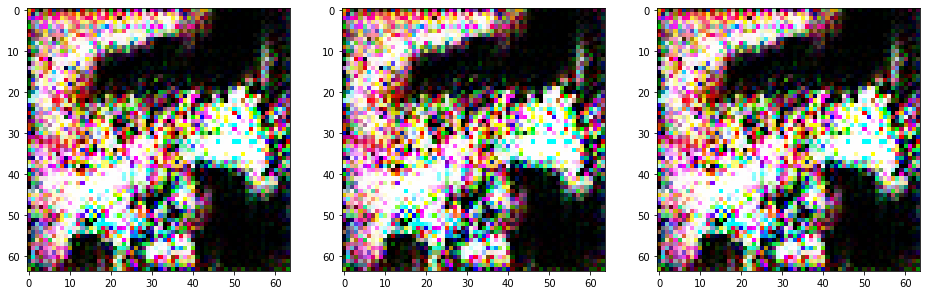

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2550
discriminator loss: [2.05055532e-04 1.00000000e+00] 
generator loss: [0.8632398843765259, 0.421875]


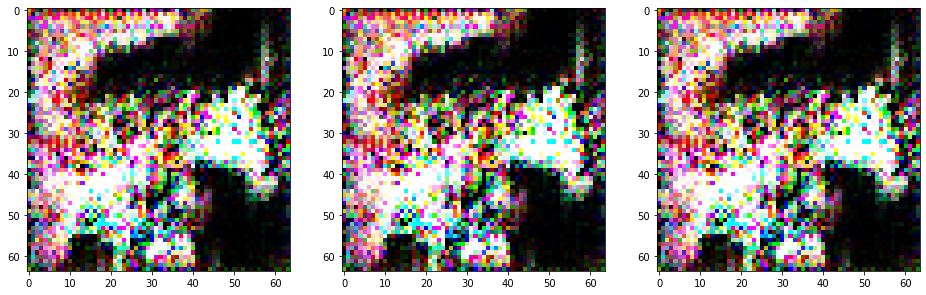

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2600
discriminator loss: [4.16743482e-04 1.00000000e+00] 
generator loss: [1.3964207172393799, 0.09375]


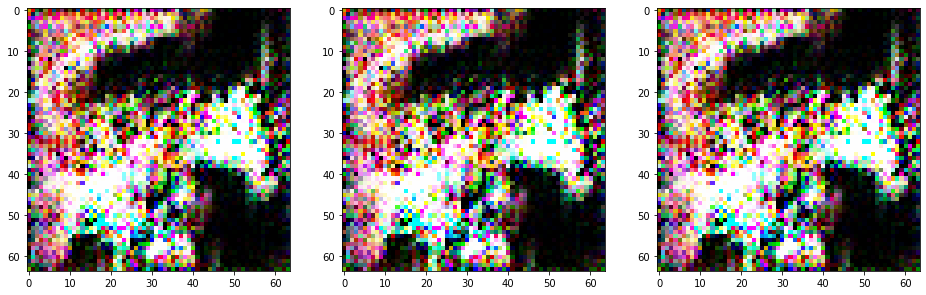

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2650
discriminator loss: [2.15918451e-04 1.00000000e+00] 
generator loss: [1.362532615661621, 0.109375]


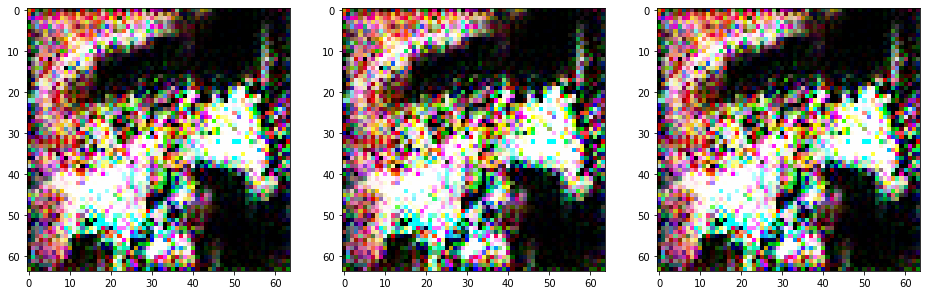

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2700
discriminator loss: [7.83215307e-04 1.00000000e+00] 
generator loss: [0.042670220136642456, 1.0]


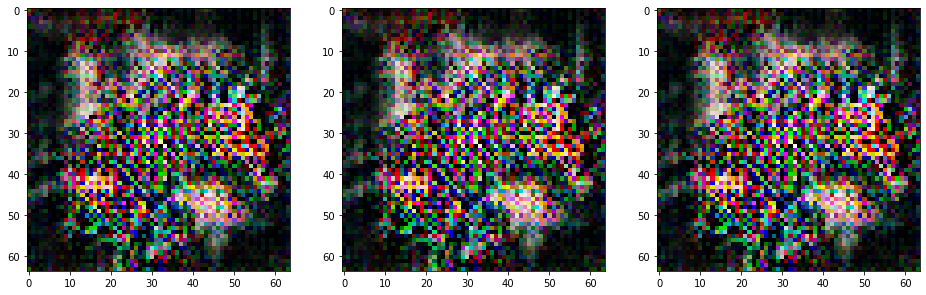

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2750
discriminator loss: [5.17470646e-04 1.00000000e+00] 
generator loss: [0.17415714263916016, 0.984375]


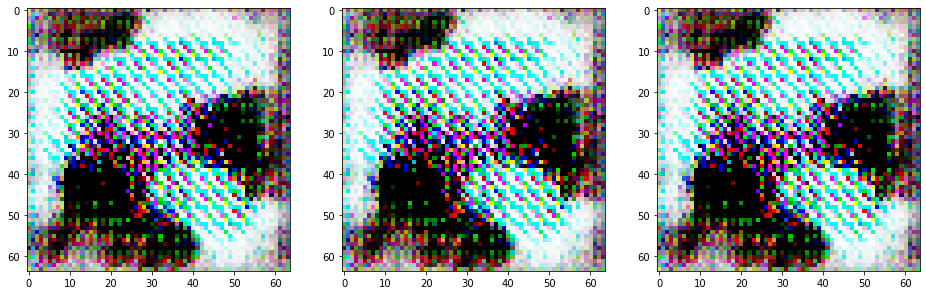

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2800
discriminator loss: [2.47611053e-04 1.00000000e+00] 
generator loss: [0.32644984126091003, 0.90625]


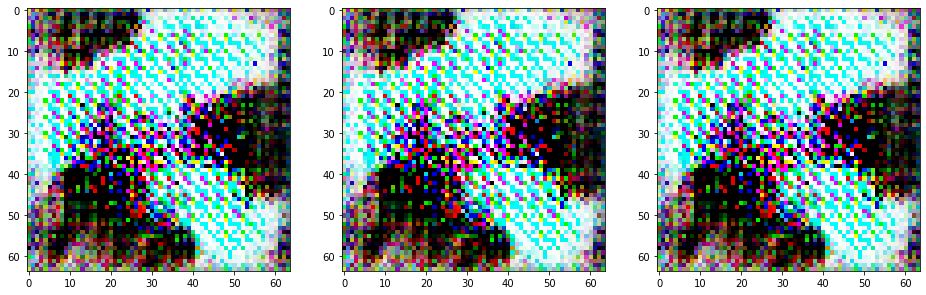

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2850
discriminator loss: [1.27831525e-04 1.00000000e+00] 
generator loss: [0.41660159826278687, 0.84375]


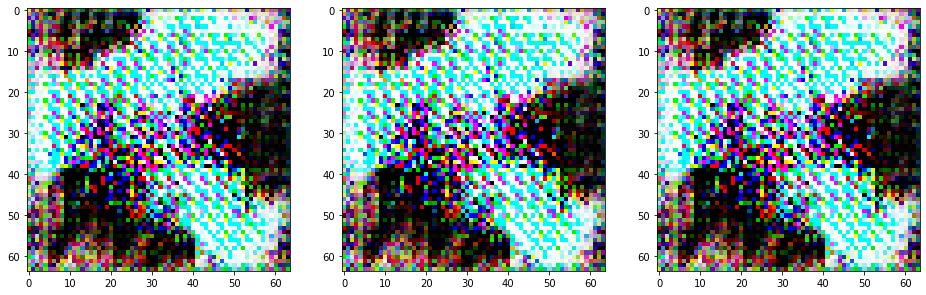

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2900
discriminator loss: [1.19210467e-04 1.00000000e+00] 
generator loss: [0.3563016653060913, 0.953125]


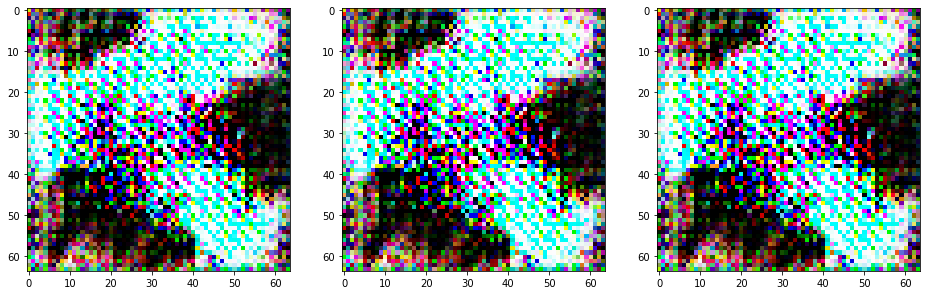

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2950
discriminator loss: [0.00127661 1.        ] 
generator loss: [0.38301408290863037, 0.9375]


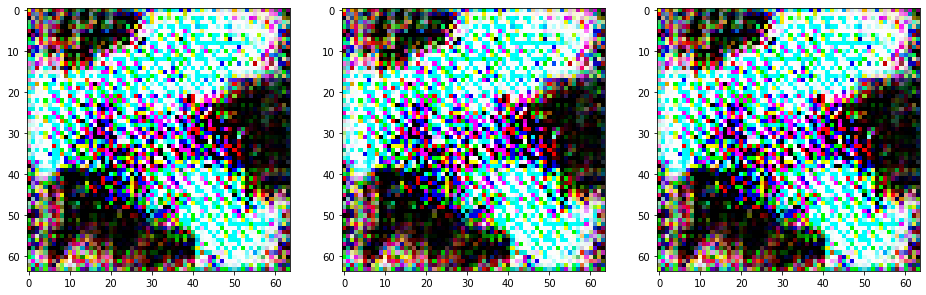

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3000
discriminator loss: [7.0959004e-05 1.0000000e+00] 
generator loss: [0.409900426864624, 0.890625]


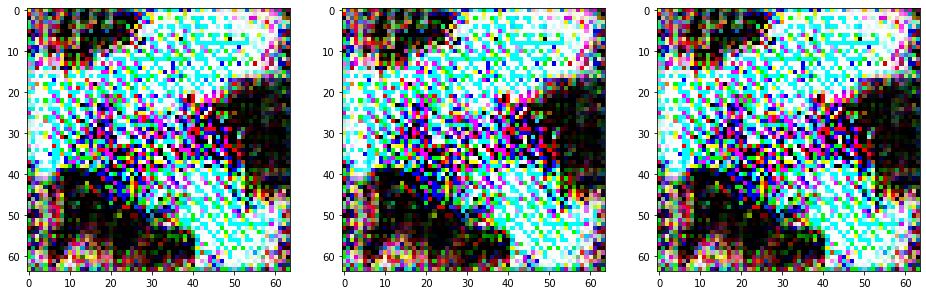

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3050
discriminator loss: [8.20989299e-05 1.00000000e+00] 
generator loss: [0.443298876285553, 0.84375]


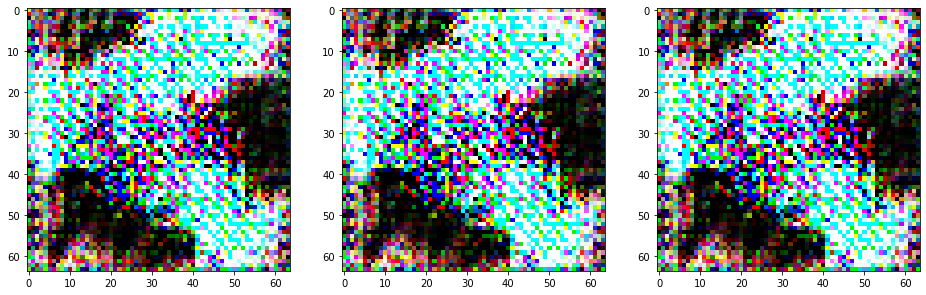

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3100
discriminator loss: [7.95490123e-05 1.00000000e+00] 
generator loss: [0.4916999936103821, 0.78125]


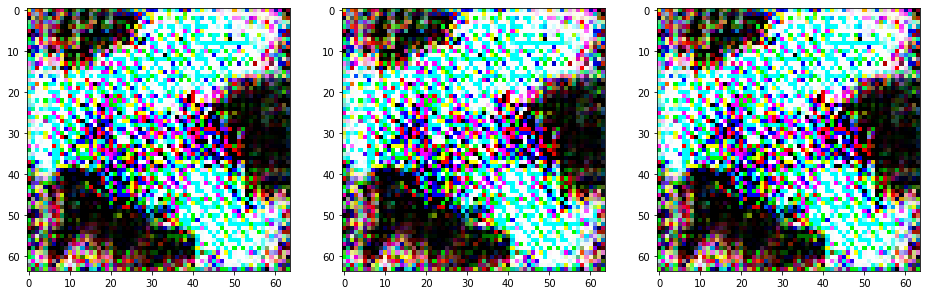

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3150
discriminator loss: [6.90969082e-05 1.00000000e+00] 
generator loss: [0.46500101685523987, 0.84375]


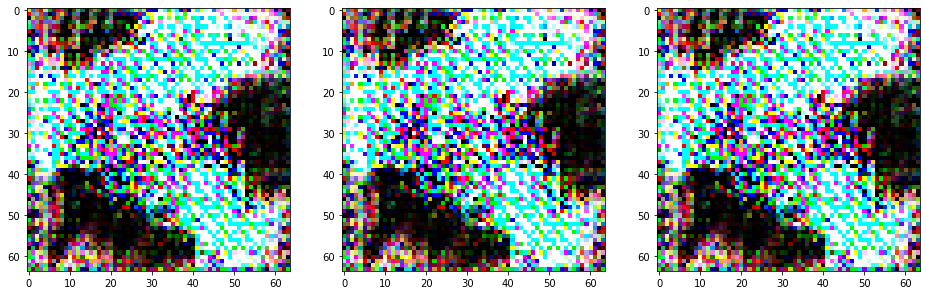

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3200
discriminator loss: [4.49631014e-04 1.00000000e+00] 
generator loss: [0.5018182396888733, 0.796875]


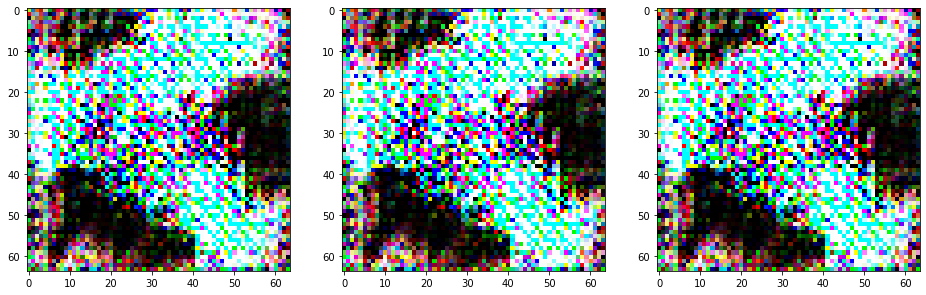

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3250
discriminator loss: [6.34775506e-05 1.00000000e+00] 
generator loss: [0.3127298951148987, 0.953125]


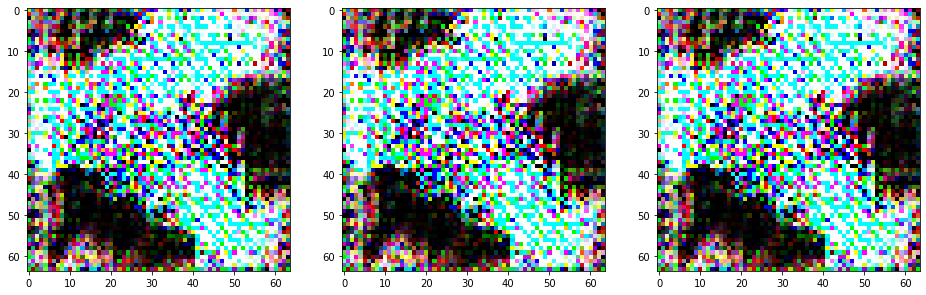

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3300
discriminator loss: [1.09739689e-04 1.00000000e+00] 
generator loss: [0.3908233642578125, 0.890625]


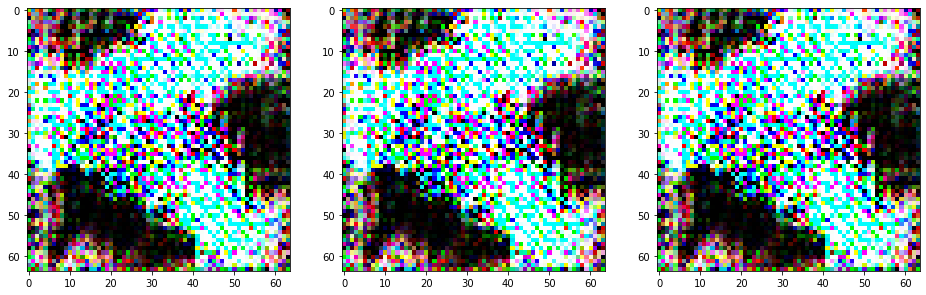

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3350
discriminator loss: [1.02372945e-04 1.00000000e+00] 
generator loss: [0.3725643754005432, 0.828125]


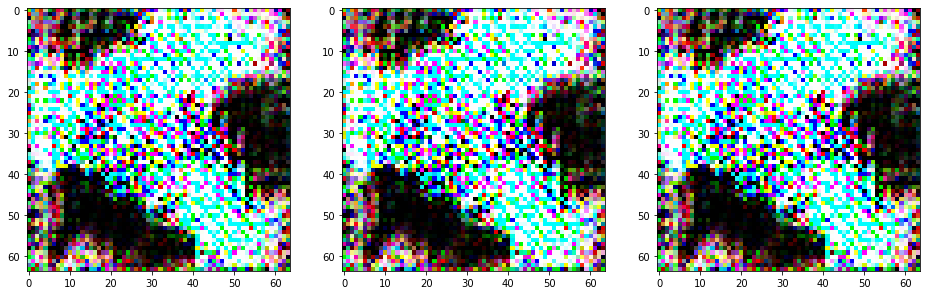

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3400
discriminator loss: [9.11259194e-05 1.00000000e+00] 
generator loss: [0.2929081320762634, 0.90625]


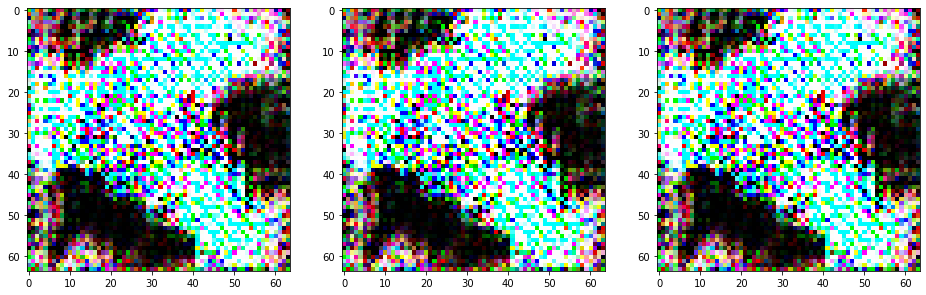

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3450
discriminator loss: [1.15126961e-04 1.00000000e+00] 
generator loss: [0.2723195254802704, 0.953125]


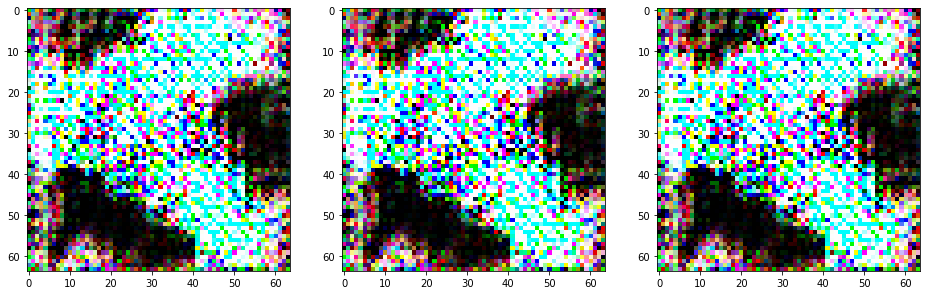

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3500
discriminator loss: [1.97446607e-04 1.00000000e+00] 
generator loss: [0.27190840244293213, 0.921875]


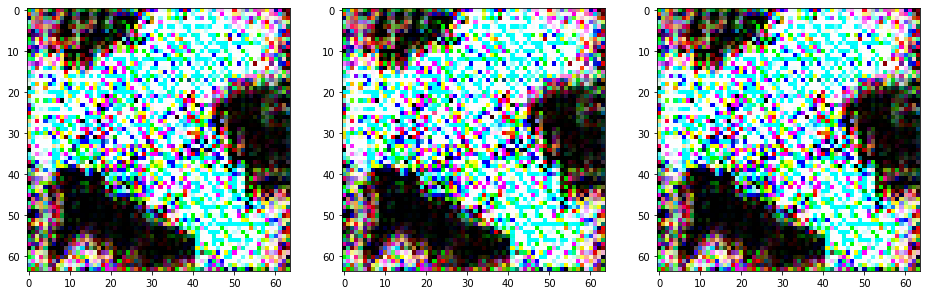

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3550
discriminator loss: [2.45473202e-04 1.00000000e+00] 
generator loss: [0.27960819005966187, 0.9375]


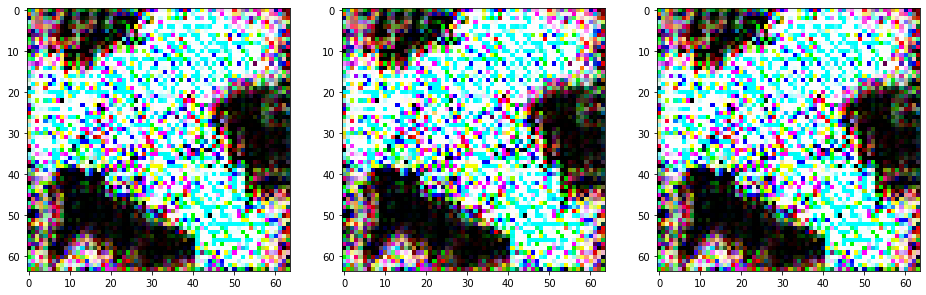

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3600
discriminator loss: [2.24807665e-04 1.00000000e+00] 
generator loss: [0.434465229511261, 0.84375]


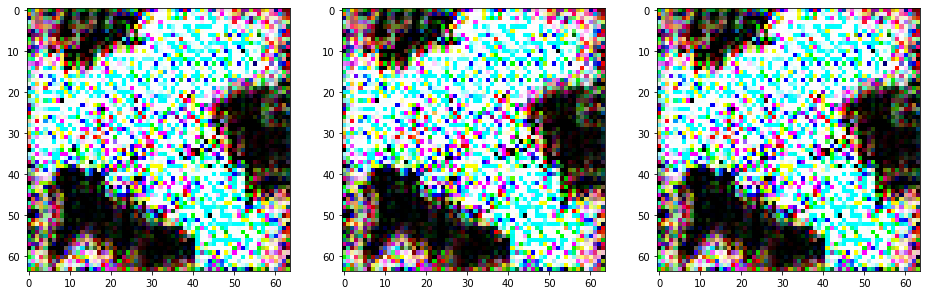

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3650
discriminator loss: [1.6487382e-04 1.0000000e+00] 
generator loss: [0.5563976168632507, 0.6875]


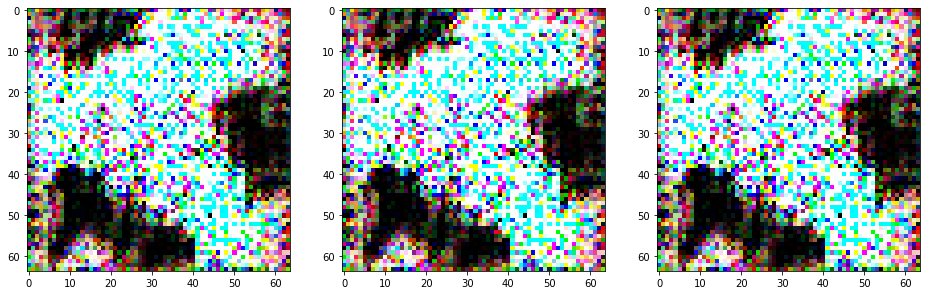

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3700
discriminator loss: [6.54959777e-05 1.00000000e+00] 
generator loss: [0.47762370109558105, 0.78125]


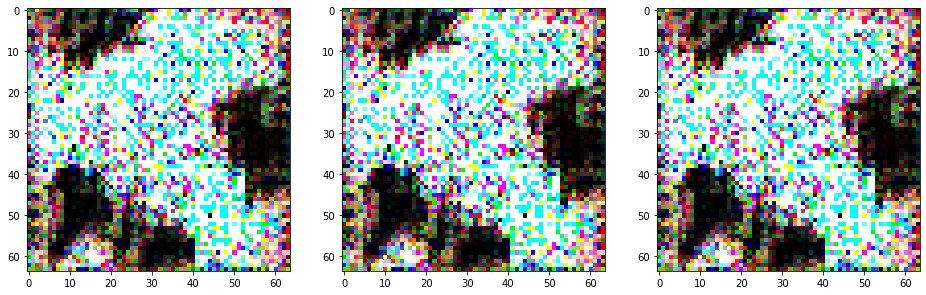

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3750
discriminator loss: [1.13541482e-04 1.00000000e+00] 
generator loss: [0.7795191407203674, 0.5625]


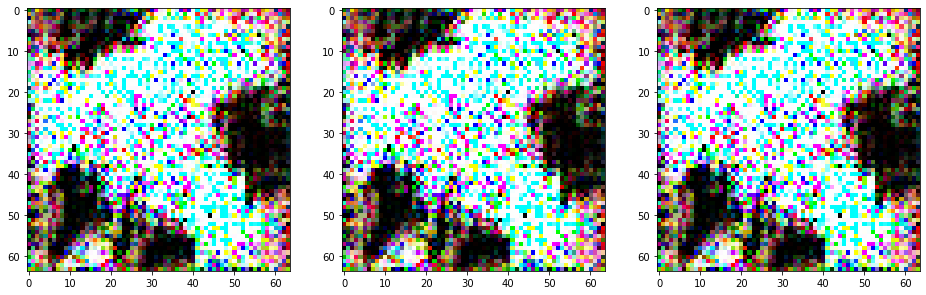

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3800
discriminator loss: [9.41963553e-05 1.00000000e+00] 
generator loss: [0.774858832359314, 0.546875]


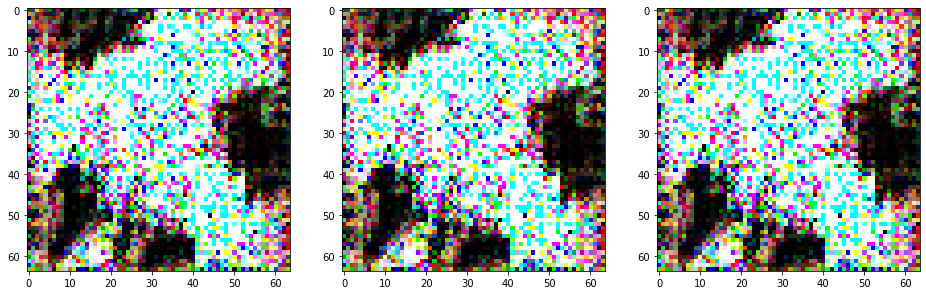

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3850
discriminator loss: [5.1821321e-05 1.0000000e+00] 
generator loss: [0.7299193143844604, 0.53125]


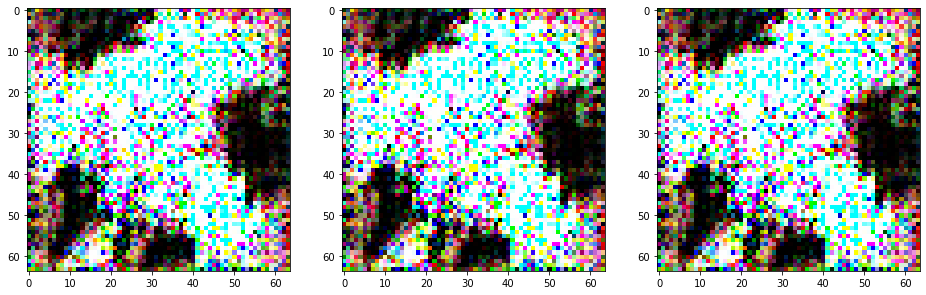

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3900
discriminator loss: [6.65958905e-05 1.00000000e+00] 
generator loss: [0.987288236618042, 0.375]


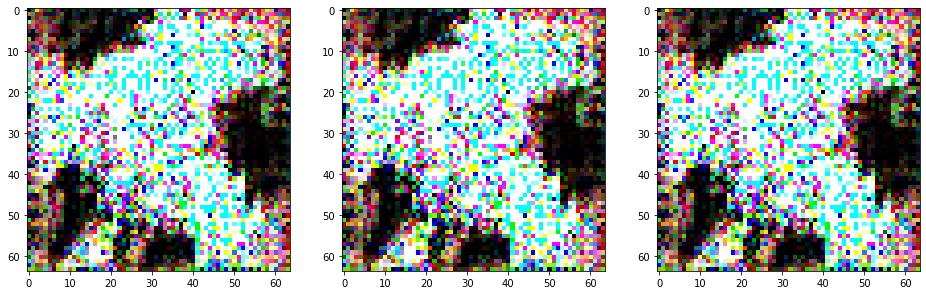

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3950
discriminator loss: [5.18305733e-05 1.00000000e+00] 
generator loss: [0.7618655562400818, 0.484375]


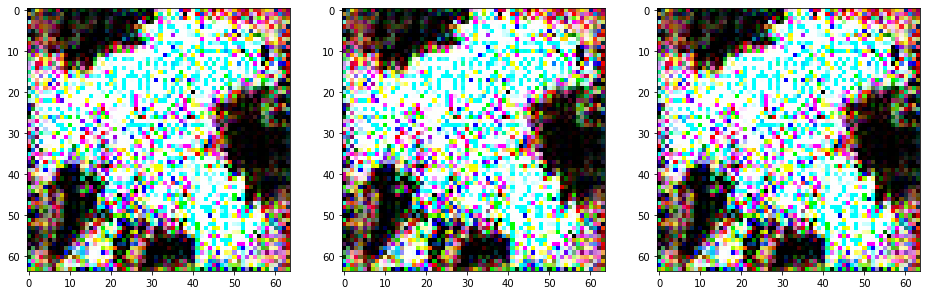

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4000
discriminator loss: [2.81635103e-05 1.00000000e+00] 
generator loss: [1.074883222579956, 0.28125]


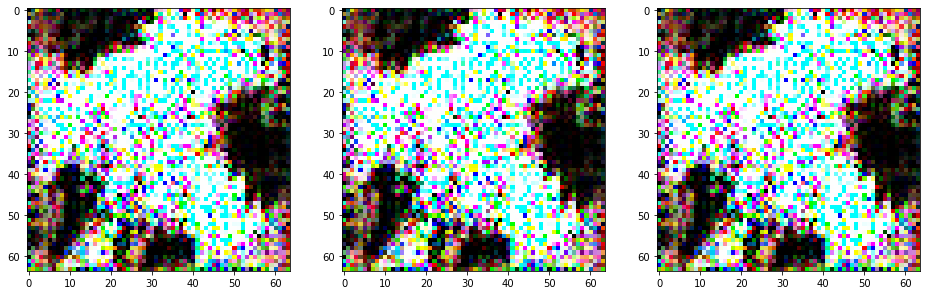

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4050
discriminator loss: [8.11505743e-05 1.00000000e+00] 
generator loss: [0.9658260941505432, 0.34375]


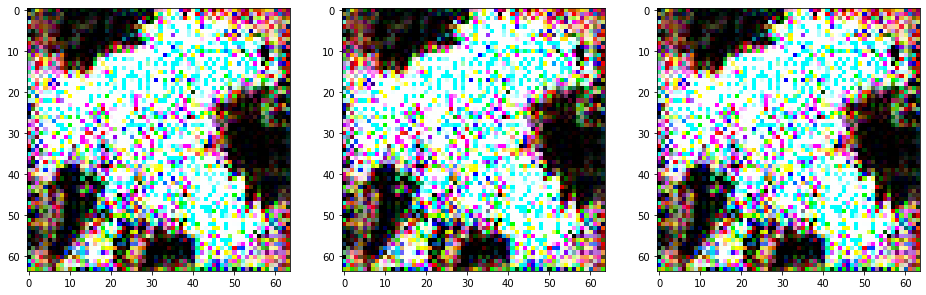

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4100
discriminator loss: [7.1058621e-05 1.0000000e+00] 
generator loss: [1.0009701251983643, 0.296875]


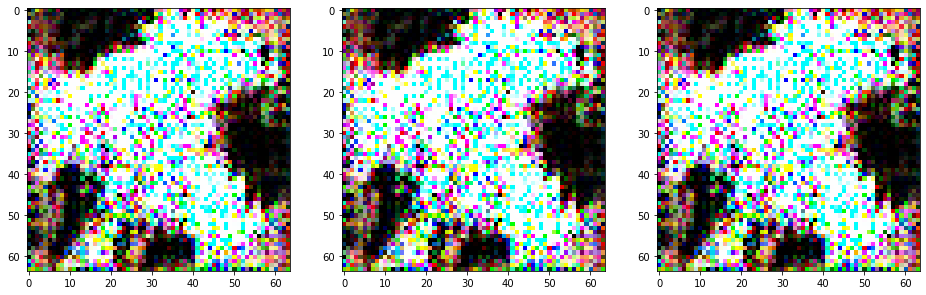

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4150
discriminator loss: [3.2132865e-05 1.0000000e+00] 
generator loss: [0.9510974287986755, 0.390625]


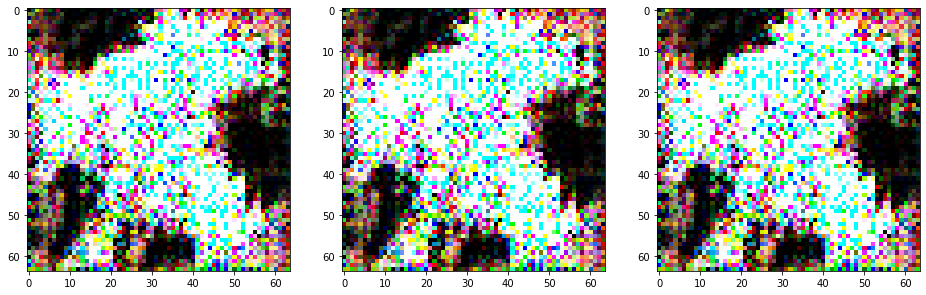

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4200
discriminator loss: [4.3743069e-05 1.0000000e+00] 
generator loss: [0.9888119697570801, 0.390625]


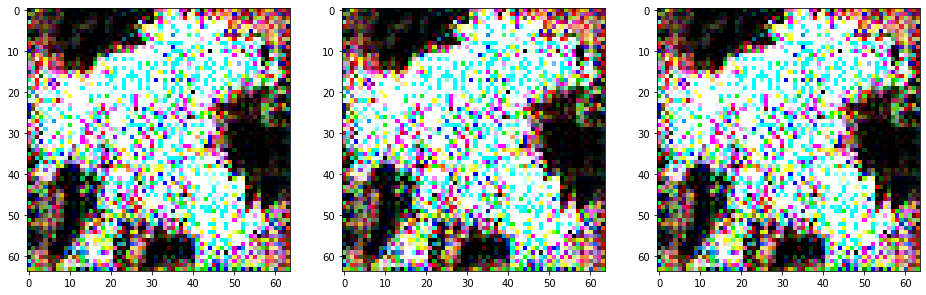

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4250
discriminator loss: [3.62540734e-05 1.00000000e+00] 
generator loss: [0.8692823052406311, 0.46875]


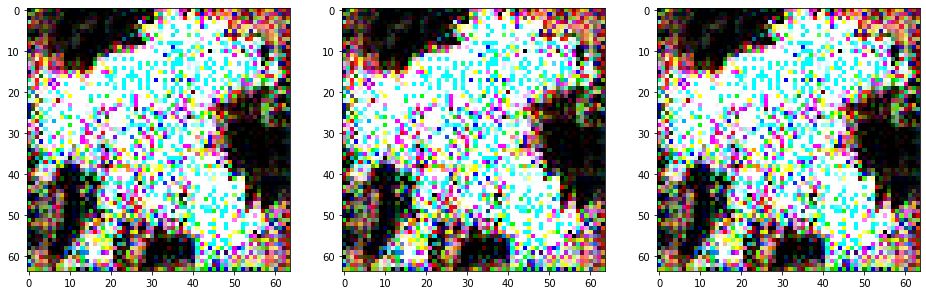

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4300
discriminator loss: [2.79295857e-05 1.00000000e+00] 
generator loss: [1.1333436965942383, 0.234375]


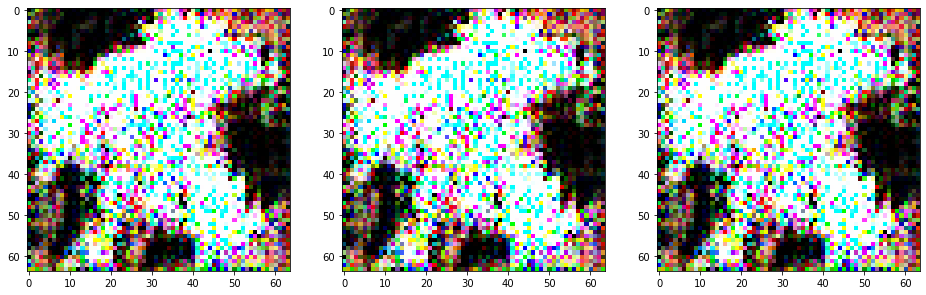

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4350
discriminator loss: [5.91077751e-05 1.00000000e+00] 
generator loss: [1.1129283905029297, 0.328125]


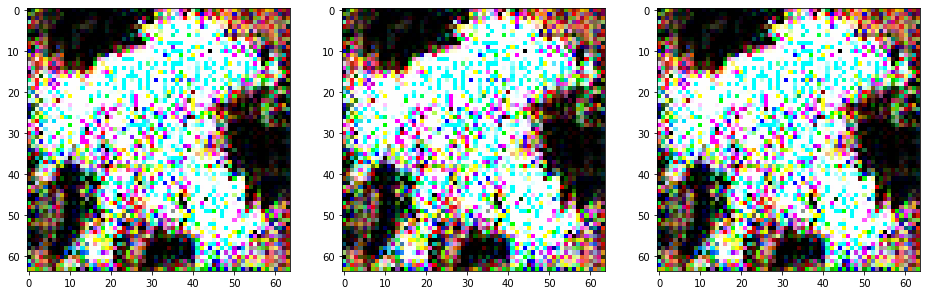

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4400
discriminator loss: [1.01142112e-04 1.00000000e+00] 
generator loss: [1.114324688911438, 0.15625]


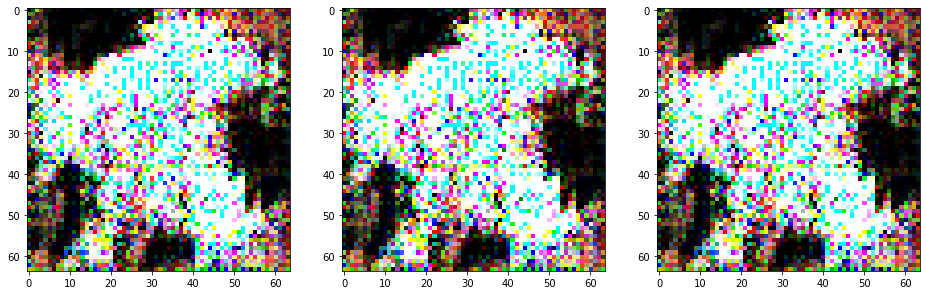

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4450
discriminator loss: [4.12419067e-05 1.00000000e+00] 
generator loss: [1.2116116285324097, 0.234375]


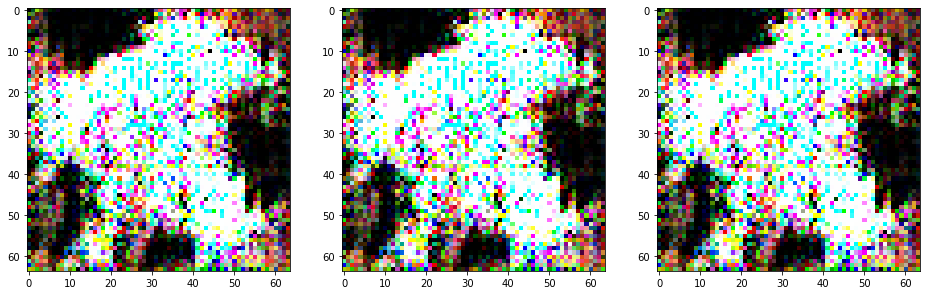

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4500
discriminator loss: [3.34638298e-05 1.00000000e+00] 
generator loss: [0.8386613726615906, 0.4375]


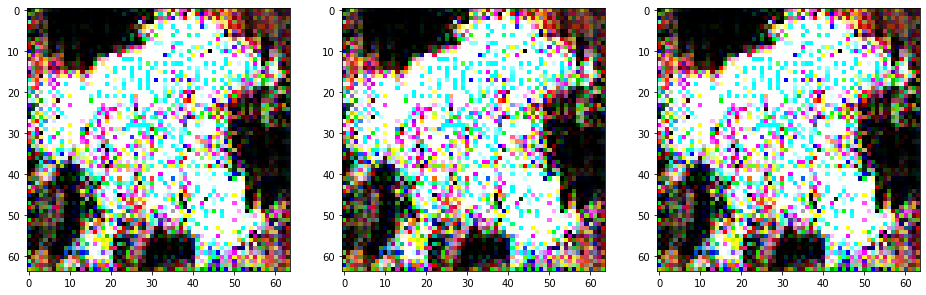

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4550
discriminator loss: [6.6309025e-05 1.0000000e+00] 
generator loss: [1.4963784217834473, 0.09375]


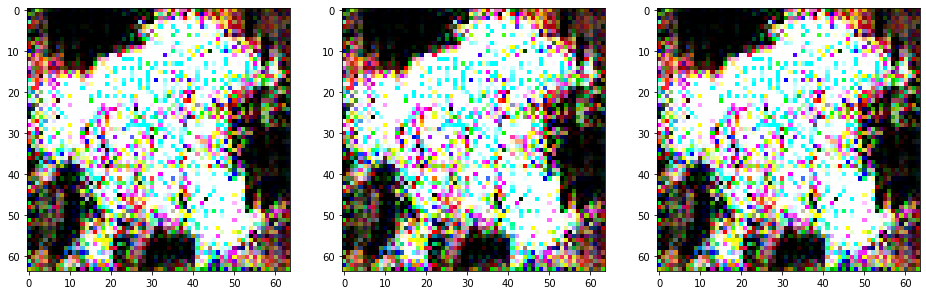

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4600
discriminator loss: [8.53326201e-05 1.00000000e+00] 
generator loss: [1.3246301412582397, 0.1875]


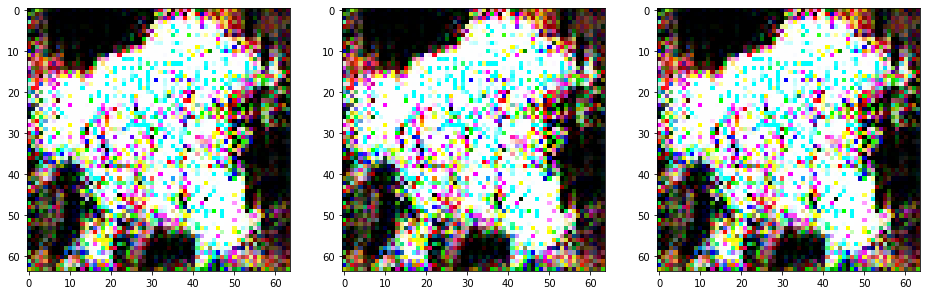

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4650
discriminator loss: [6.39682112e-05 1.00000000e+00] 
generator loss: [1.151545763015747, 0.21875]


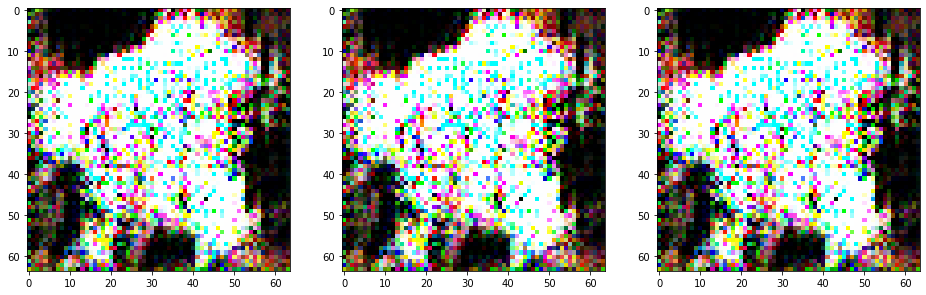

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4700
discriminator loss: [9.33043884e-05 1.00000000e+00] 
generator loss: [1.4054582118988037, 0.1875]


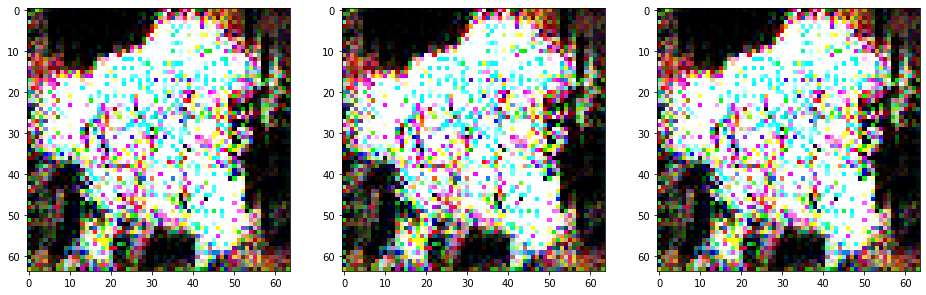

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4750
discriminator loss: [9.17434008e-05 1.00000000e+00] 
generator loss: [1.5577552318572998, 0.046875]


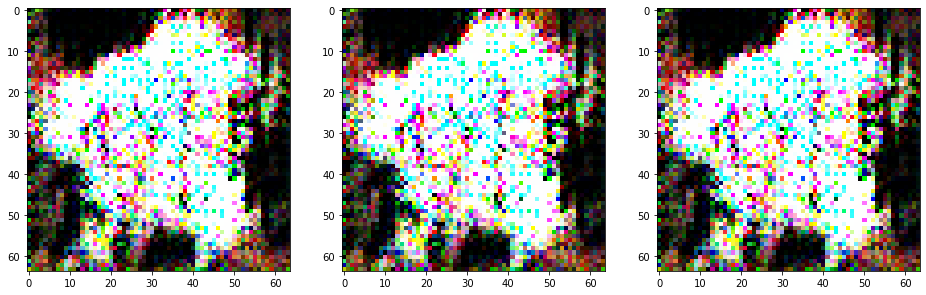

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4800
discriminator loss: [1.1086095e-04 1.0000000e+00] 
generator loss: [1.4046354293823242, 0.15625]


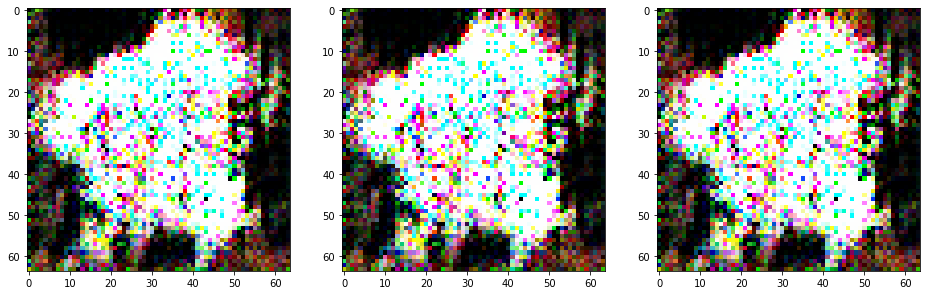

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4850
discriminator loss: [2.62625785e-04 1.00000000e+00] 
generator loss: [1.6089212894439697, 0.109375]


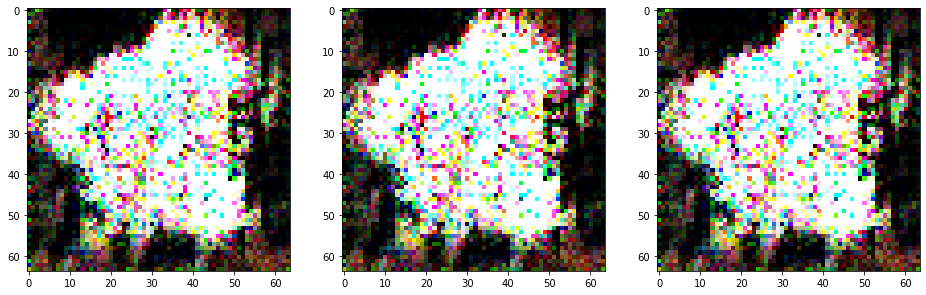

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4900
discriminator loss: [8.20450776e-04 1.00000000e+00] 
generator loss: [1.5632262229919434, 0.0625]


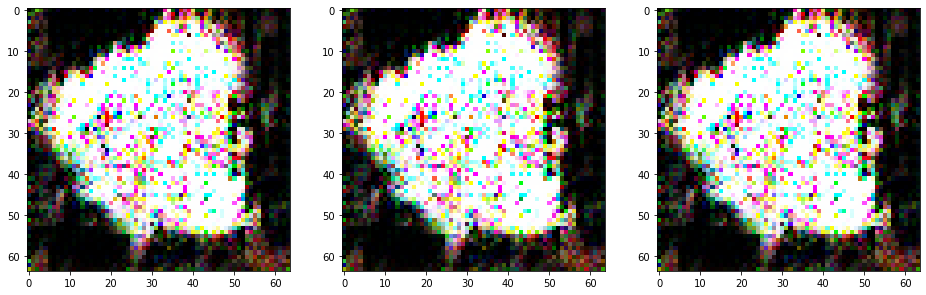

KeyboardInterrupt: 

In [80]:
# Training Loop 
EPOCHS = 10001
BATCH_SIZE = 64

num_generated_images = 3
fixed_seeds = np.random.normal(0, 1, (num_generated_images, seed_input_size))

y_real = np.ones((BATCH_SIZE, 1))
y_fake = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    
    # Real Images
    idx = np.random.randint(0, len(image_dataset), BATCH_SIZE)
    x_real = image_dataset[idx]
    
    # Fake Images
    seed = np.random.normal(0, 1, (BATCH_SIZE, seed_input_size))
    x_fake = generator_model.predict(seed)
    
    # Discriminator loss computed on real and fake images
    discriminator_loss_real = discriminator_model.train_on_batch(x_real, y_real)
    discriminator_loss_fake = discriminator_model.train_on_batch(x_fake, y_fake)
    
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
    
    # Loss of the combined model indicating how well the generator did at fooling the discriminator
    generator_loss = combined_model.train_on_batch(seed, y_real)
    
    if epoch % 50 == 0:
        
        print(f"epoch: {epoch}\ndiscriminator loss: {discriminator_loss} \ngenerator loss: {generator_loss}")    
        output = generator_model.predict(fixed_seeds)
        fig = plt.figure(figsize=(16, 60))
        
        for i in range(num_generated_images):
            fig.add_subplot(1, num_generated_images, i + 1)
            plt.imshow(output[i])
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

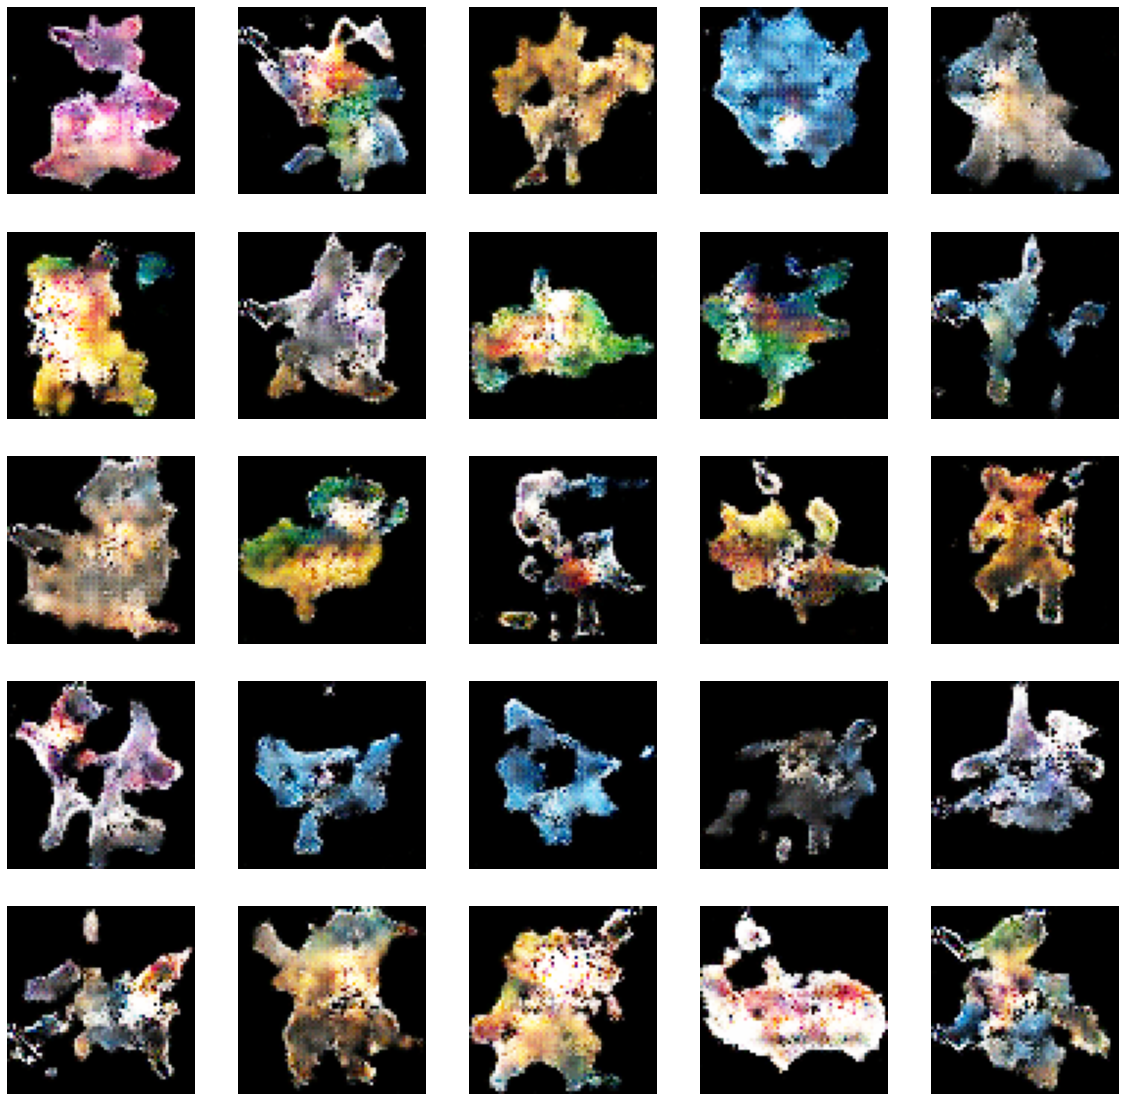

In [31]:
r, c = 5, 5

f = plt.figure(figsize=(20, 20))

seed = np.random.normal(0, 1, (r * c, seed_input_size))
ims = generator_model.predict(seed)

for i in range(r * c):
  f.add_subplot(r, c, i + 1)
  plt.imshow(ims[i])
  plt.axis('off')
plt.show()

In [32]:
generator_model.save("../models/generator.h5")
discriminator_model.save("../models/discriminator.h5")
combined_model.save("../models/combined.h5")